In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 35.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
!pip install bayesian-optimization


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=175587286140343594a907a9f7defb2352cfb1c5e5db955b7febcdeb8f65ddd3
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [3]:
!pip install shap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.0 MB/s 


In [4]:
!pip install pystan==2.19.1.1 fbprophet


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 65 kB/s 
     |████████████████████████████████| 64 kB 1.4 MB/s 
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
Failed to build fbprophet
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.4
    Uninstalling cmdstanpy-1.0.4:
      Successfully uninstalled cmdstanpy-1.0.4
    Running setup.py install for fbprophet ... done
  DEPRECATION: fbprophet was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
ERROR: pip's dependency resolv

In [7]:
!pip install gluonts


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 17.4 MB/s 


In [5]:
!pip install tqdm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 1.9 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [9]:
!pip install gluonts


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.1 MB/s 


In [7]:
import mxnet as mx


In [277]:
import pickle
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import tensorflow as tf
import xgboost as xgb
from bayes_opt import BayesianOptimization
from fbprophet import Prophet
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from tqdm import tqdm



# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

print(tf.__version__)

2.8.2


In [278]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [12]:
bitcoin = pd.read_excel('/content/Final_Dataset_1Aug.xlsx', parse_dates=['Date'])
bitcoin.set_index('Date', inplace=True)
bitcoin.head(2000)

,XBTUSD,SPX Index,MXEU Index,NKY Index,SHCOMP Index,SENSEX Index,MCX Index,CO1 Comdty,XAU Index
Date,,,,,,,,,
2022-07-12,19443.28,3818.80,140.90563,192.68847,487.95774,678.29679,22458.14286,99.49,105.66
2022-07-11,20409.54,3854.43,140.24748,195.14047,493.16624,684.36393,22385.86703,107.10,107.60
2022-07-10,20972.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-09,21672.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-08,21846.53,3899.38,142.36291,194.73592,501.31118,687.18793,22731.47461,107.02,108.97
...,...,...,...,...,...,...,...,...,...
2017-07-11,2328.94,2425.53,146.41930,177.23107,NaN,NaN,NaN,NaN,80.43
2017-07-10,2384.54,2427.43,146.79655,175.90207,NaN,NaN,NaN,NaN,79.93
2017-07-09,2527.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
bitcoin.columns

Index(['XBTUSD', 'SPX Index', 'MXEU Index', 'NKY Index', 'SHCOMP Index',
       'SENSEX Index', 'MCX Index', 'CO1 Comdty', 'XAU Index'],
      dtype='object')

In [14]:
bf = bitcoin.iloc[::-1]
bf

,XBTUSD,SPX Index,MXEU Index,NKY Index,SHCOMP Index,SENSEX Index,MCX Index,CO1 Comdty,XAU Index
Date,,,,,,,,,
2017-07-06,2597.68,2409.75,146.67779,176.45451,NaN,NaN,NaN,NaN,78.98
2017-07-07,2514.87,2425.18,146.41495,174.73994,NaN,NaN,NaN,NaN,77.50
2017-07-09,2527.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-10,2384.54,2427.43,146.79655,175.90207,NaN,NaN,NaN,NaN,79.93
2017-07-11,2328.94,2425.53,146.41930,177.23107,NaN,NaN,NaN,NaN,80.43
...,...,...,...,...,...,...,...,...,...
2022-07-08,21846.53,3899.38,142.36291,194.73592,501.31118,687.18793,22731.47461,107.02,108.97
2022-07-09,21672.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-10,20972.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#we will check the null values 
bf.isnull()

,XBTUSD,SPX Index,MXEU Index,NKY Index,SHCOMP Index,SENSEX Index,MCX Index,CO1 Comdty,XAU Index
Date,,,,,,,,,
2017-07-06,False,False,False,False,True,True,True,True,False
2017-07-07,False,False,False,False,True,True,True,True,False
2017-07-09,False,True,True,True,True,True,True,True,True
2017-07-10,False,False,False,False,True,True,True,True,False
2017-07-11,False,False,False,False,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...
2022-07-08,False,False,False,False,False,False,False,False,False
2022-07-09,False,True,True,True,True,True,True,True,True
2022-07-10,False,True,True,True,True,True,True,True,True


In [16]:
bf = bf.fillna(method='ffill')
bf

,XBTUSD,SPX Index,MXEU Index,NKY Index,SHCOMP Index,SENSEX Index,MCX Index,CO1 Comdty,XAU Index
Date,,,,,,,,,
2017-07-06,2597.68,2409.75,146.67779,176.45451,NaN,NaN,NaN,NaN,78.98
2017-07-07,2514.87,2425.18,146.41495,174.73994,NaN,NaN,NaN,NaN,77.50
2017-07-09,2527.97,2425.18,146.41495,174.73994,NaN,NaN,NaN,NaN,77.50
2017-07-10,2384.54,2427.43,146.79655,175.90207,NaN,NaN,NaN,NaN,79.93
2017-07-11,2328.94,2425.53,146.41930,177.23107,NaN,NaN,NaN,NaN,80.43
...,...,...,...,...,...,...,...,...,...
2022-07-08,21846.53,3899.38,142.36291,194.73592,501.31118,687.18793,22731.47461,107.02,108.97
2022-07-09,21672.98,3899.38,142.36291,194.73592,501.31118,687.18793,22731.47461,107.02,108.97
2022-07-10,20972.87,3899.38,142.36291,194.73592,501.31118,687.18793,22731.47461,107.02,108.97


In [17]:
bf = bf.fillna(method='bfill')
bf

,XBTUSD,SPX Index,MXEU Index,NKY Index,SHCOMP Index,SENSEX Index,MCX Index,CO1 Comdty,XAU Index
Date,,,,,,,,,
2017-07-06,2597.68,2409.75,146.67779,176.45451,480.00682,497.01333,25094.32078,48.42,78.98
2017-07-07,2514.87,2425.18,146.41495,174.73994,480.00682,497.01333,25094.32078,48.42,77.50
2017-07-09,2527.97,2425.18,146.41495,174.73994,480.00682,497.01333,25094.32078,48.42,77.50
2017-07-10,2384.54,2427.43,146.79655,175.90207,480.00682,497.01333,25094.32078,48.42,79.93
2017-07-11,2328.94,2425.53,146.41930,177.23107,480.00682,497.01333,25094.32078,48.42,80.43
...,...,...,...,...,...,...,...,...,...
2022-07-08,21846.53,3899.38,142.36291,194.73592,501.31118,687.18793,22731.47461,107.02,108.97
2022-07-09,21672.98,3899.38,142.36291,194.73592,501.31118,687.18793,22731.47461,107.02,108.97
2022-07-10,20972.87,3899.38,142.36291,194.73592,501.31118,687.18793,22731.47461,107.02,108.97


In [18]:
bf.describe()

,XBTUSD,SPX Index,MXEU Index,NKY Index,SHCOMP Index,SENSEX Index,MCX Index,CO1 Comdty,XAU Index
count,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000
mean,20190.988292,3370.058322,154.381147,217.878619,478.386990,591.529099,26564.187325,66.578562,109.724458
std,17878.849403,704.927534,16.281130,29.033493,58.967275,110.285676,3360.424935,19.365265,30.175475
min,1865.670000,2237.400000,101.160520,149.962220,358.387240,340.407210,14824.718350,19.330000,61.840000
25%,7120.480000,2781.010000,143.601290,196.981080,420.875010,512.254190,24376.424600,55.950000,82.040000
50%,10182.760000,3120.180000,152.699690,209.363370,487.817360,553.286770,26577.764100,65.740000,105.130000
75%,36168.200000,4019.870000,165.573040,246.104740,528.420290,688.175420,28558.536080,74.780000,137.780000
max,67734.040000,4796.560000,186.098940,287.730190,578.150150,828.967620,33567.601910,127.980000,167.760000


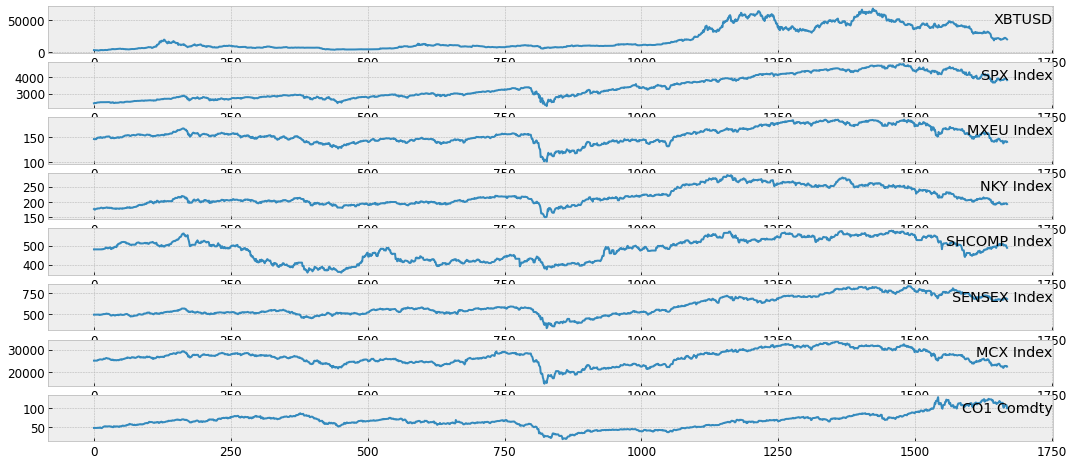

In [19]:
values = bf.values
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(bf.columns[group], y=0.5, loc='right')
    i += 1


plt.show()

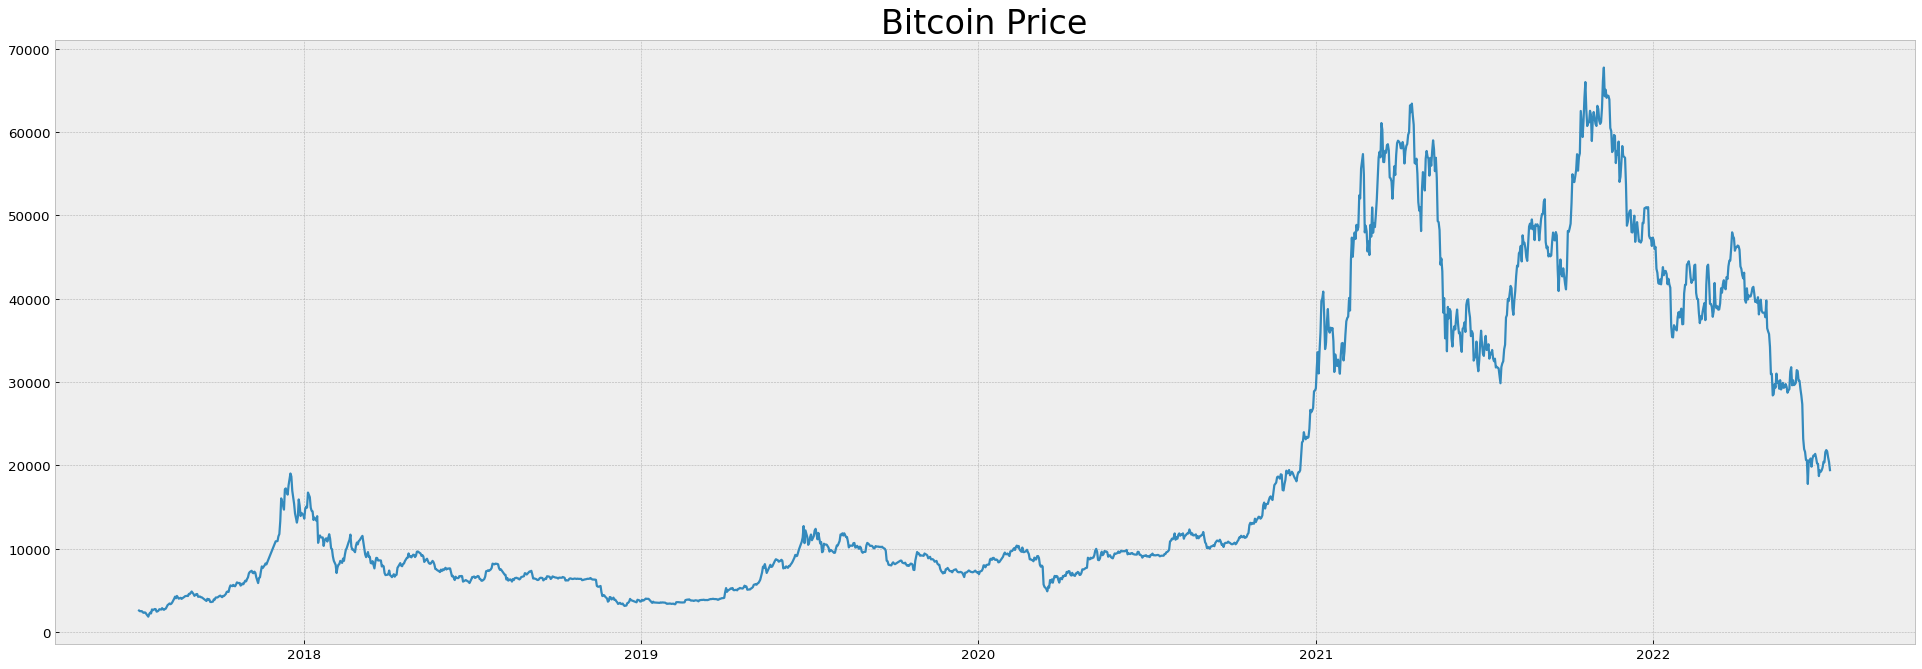

In [20]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Bitcoin Price', fontsize=30)

plt.plot(bf.XBTUSD)

In [22]:
import seaborn as sns
num= bf.columns
corr_df=bf[num]  #New dataframe to calculate correlation between numeric features
cor= corr_df.corr(method='pearson')

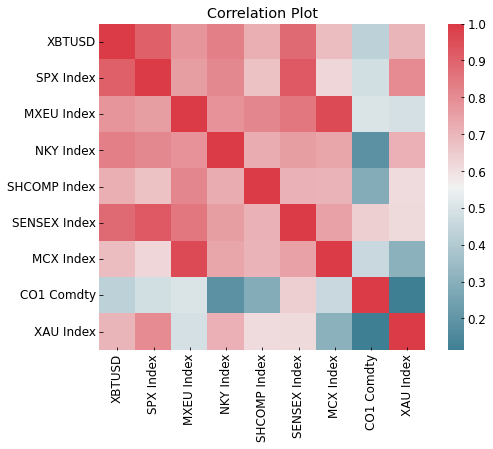

In [23]:
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [ ]:
#Decomposing our time series
# 1.Automatic time series decomposition

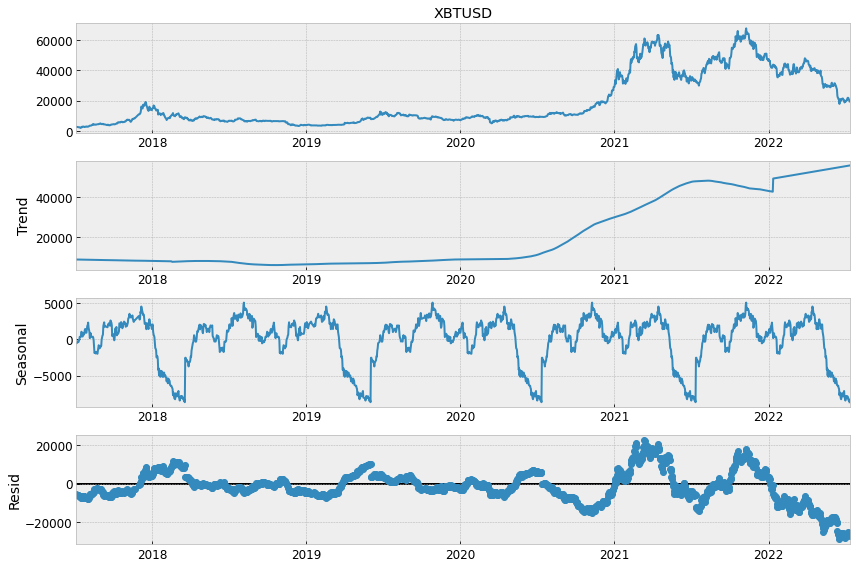

In [24]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(bf.XBTUSD, model='additive', extrapolate_trend='freq', period=365) # additive seasonal index
fig = decomposition.plot()
plt.show()

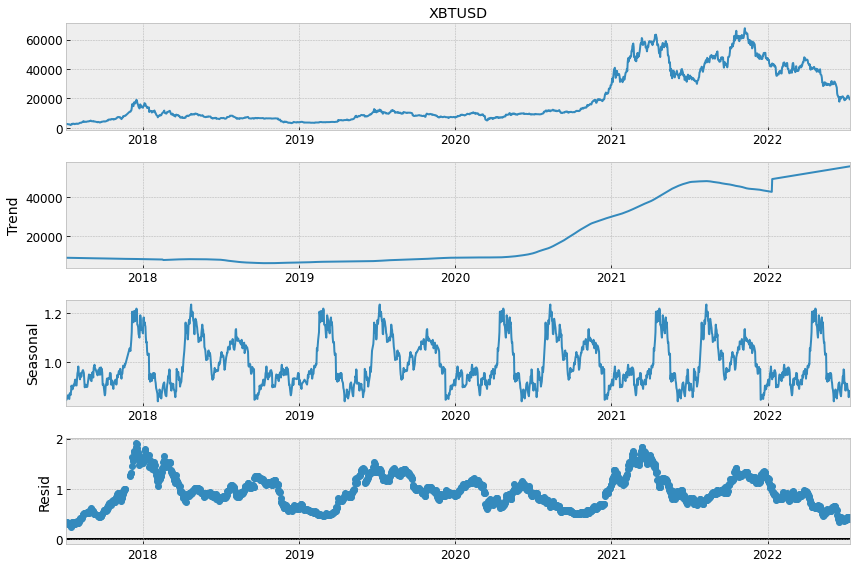

In [25]:
decomposition = sm.tsa.seasonal_decompose(bf.XBTUSD, model='multiplicative', extrapolate_trend='freq', period=365) # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

In [26]:
#Now we will try some methods to check for trend in our series:

# 1.Automatic decomposing
# 2.Moving average
# 3.Fit a linear regression model to identify trend

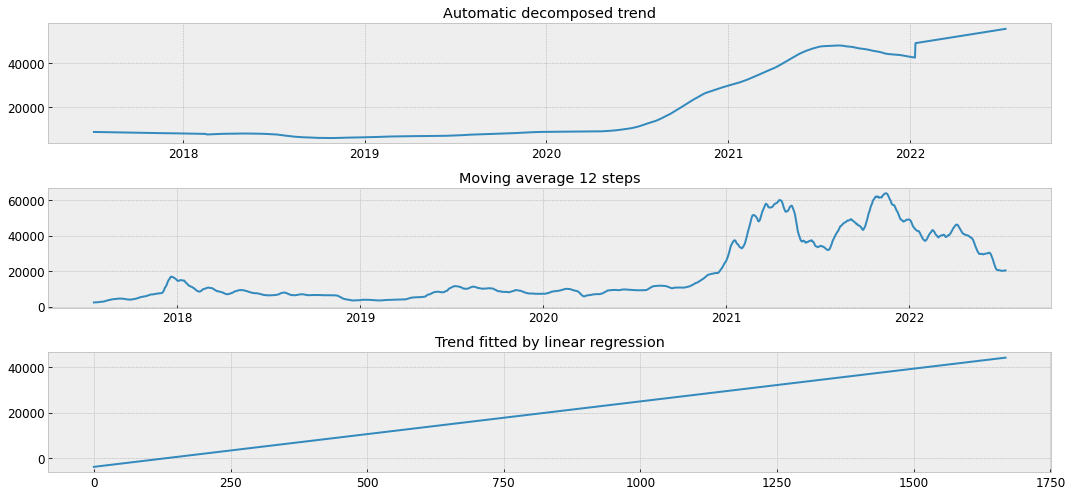

In [27]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(decomposition.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = bf.XBTUSD.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(bf.XBTUSD))]
X = np.reshape(X, (len(X), 1))
y = bf.XBTUSD.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

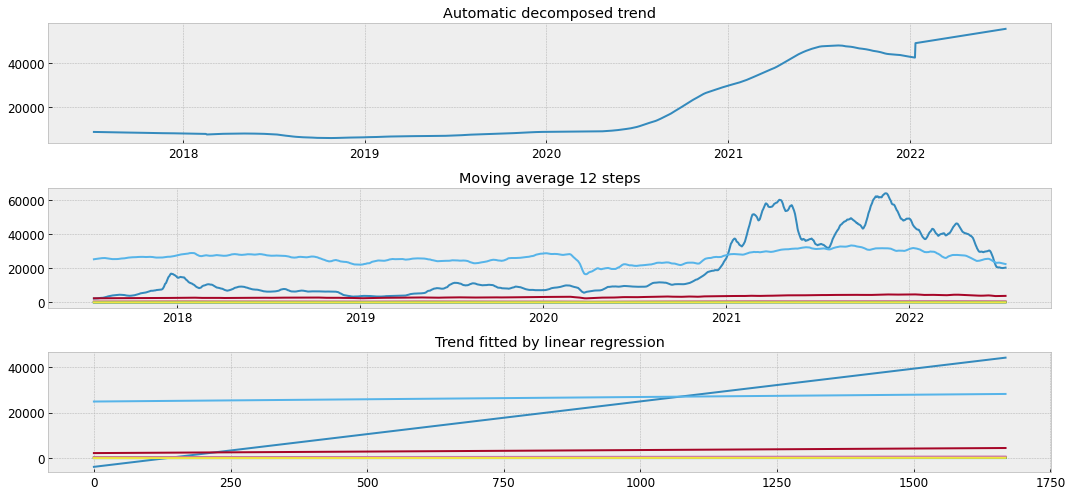

In [28]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(decomposition.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = bf.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(bf.XBTUSD))]
X = np.reshape(X, (len(X), 1))
y = bf.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

In [ ]:
# Seasonality

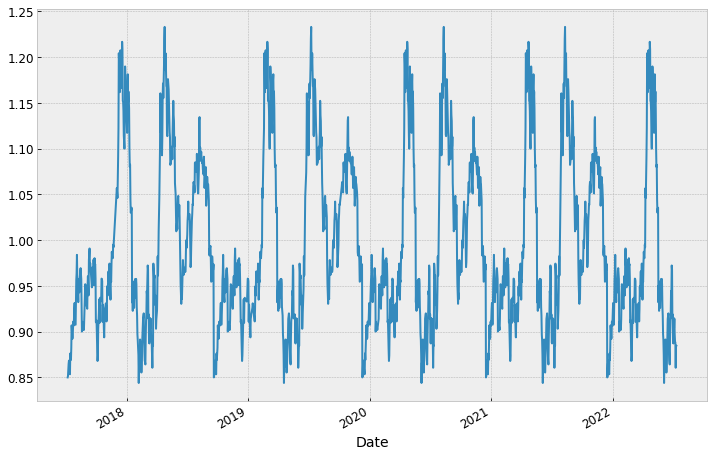

In [29]:
result=seasonal_decompose(bf['XBTUSD'], model='multiplicable', extrapolate_trend='freq', period=365)
result.seasonal.plot()

In [ ]:
#result1=seasonal_decompose(bf, model='multiplicable', extrapolate_trend='freq', period=365)
#result1.seasonal.plot()

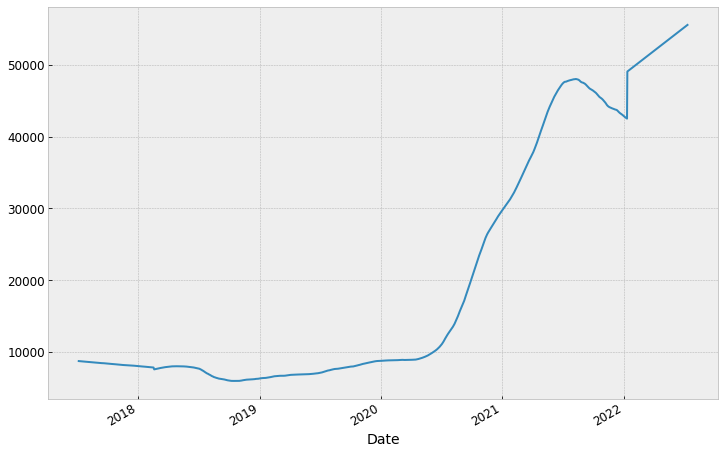

In [30]:
result.trend.plot()

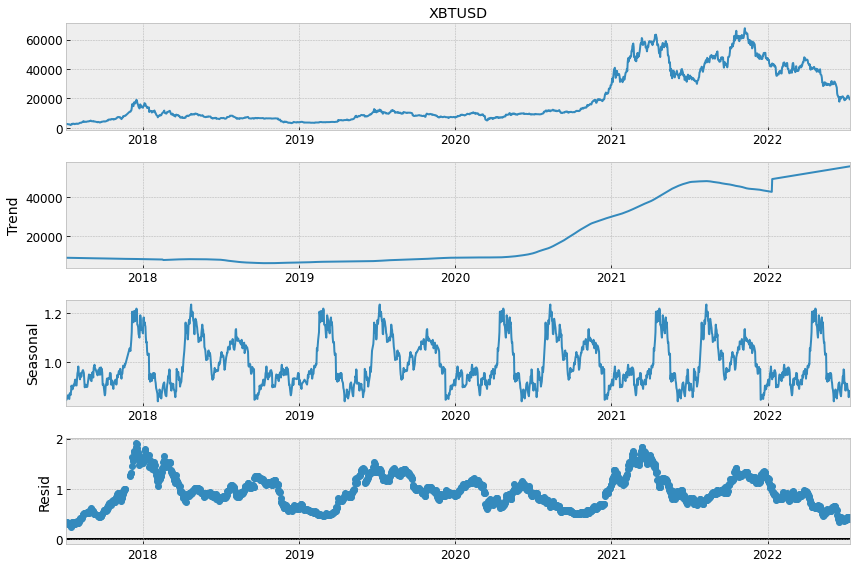

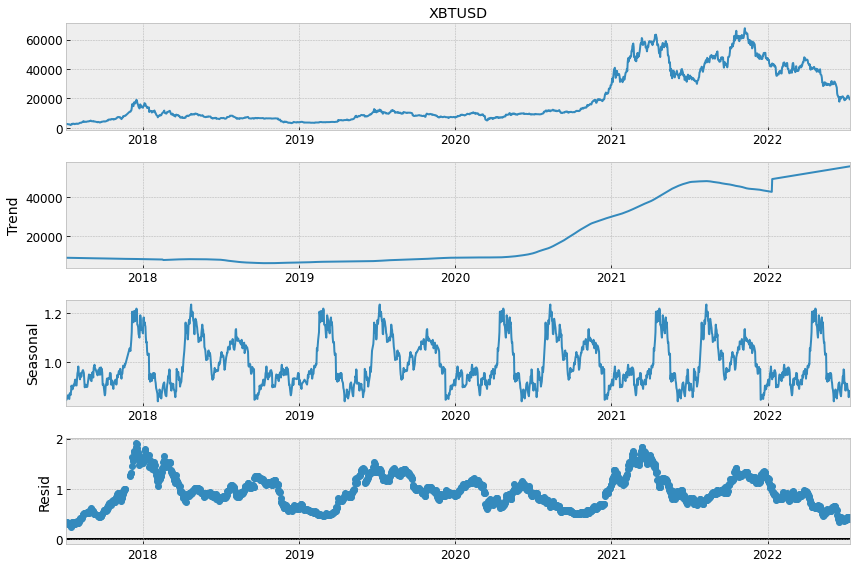

In [31]:
result.plot()

In [ ]:
# INTERPRETATION


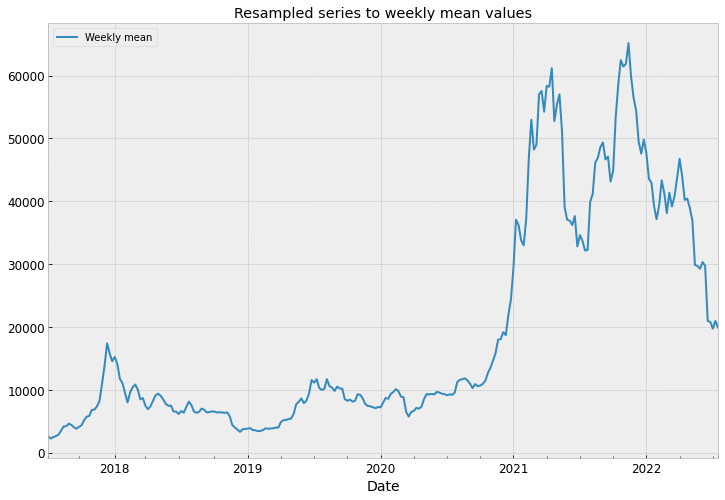

In [32]:
# Looking for weekly seasonality
resample = bf.resample('W')
weekly_mean = resample.mean()
weekly_mean.XBTUSD.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()

In [ ]:
# Manual methods to find seasonalities


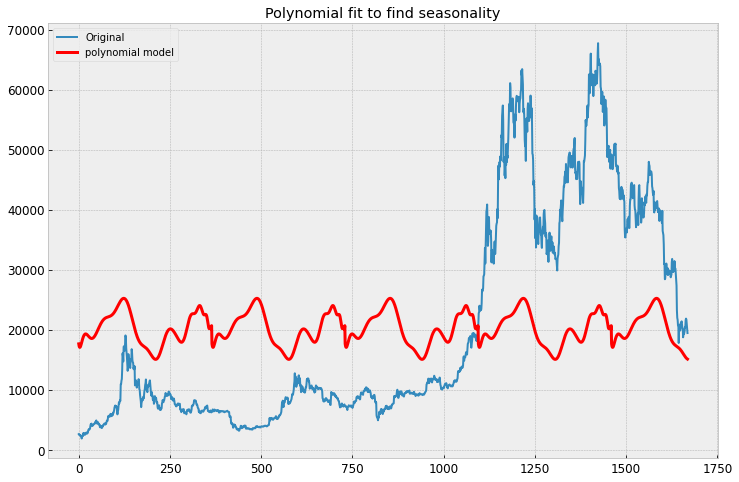

In [33]:
# Fix xticks to show dates
# fit polynomial: x^2*b1 + x*b2 + ... + bn
series = bf.XBTUSD.values
X = [i % 365 for i in range(0, len(series))]
y = series
degree = 100
coef = np.polyfit(X, y, degree)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(series, label='Original')
plt.plot(curve, color='red', linewidth=3, label='polynomial model')
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()

In [ ]:
# Noise

Text(0.5, 1.0, 'Mean over time')

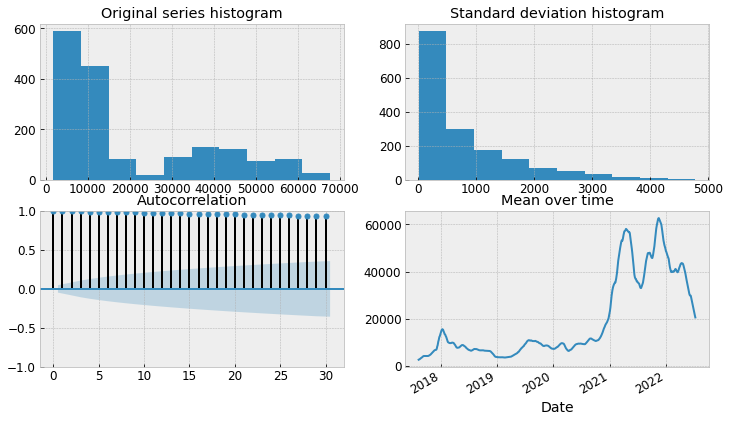

In [34]:
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

bf.XBTUSD.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = bf.XBTUSD.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = bf.XBTUSD.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

In [ ]:
# Check for sationarity
# Autocorrelation and Partial autocorrelation plots

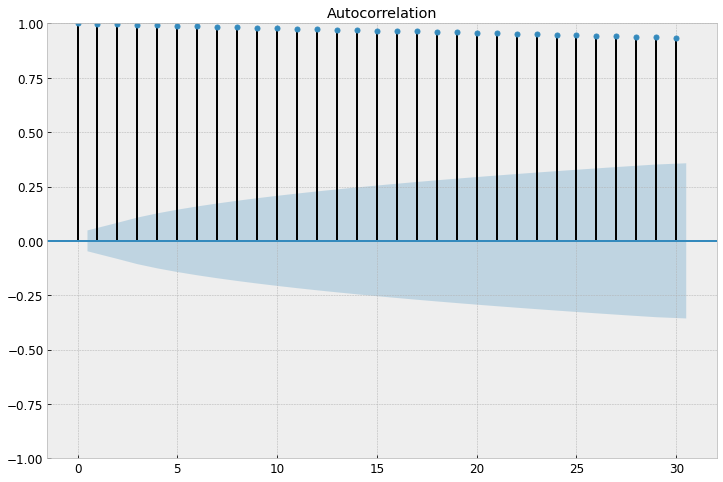

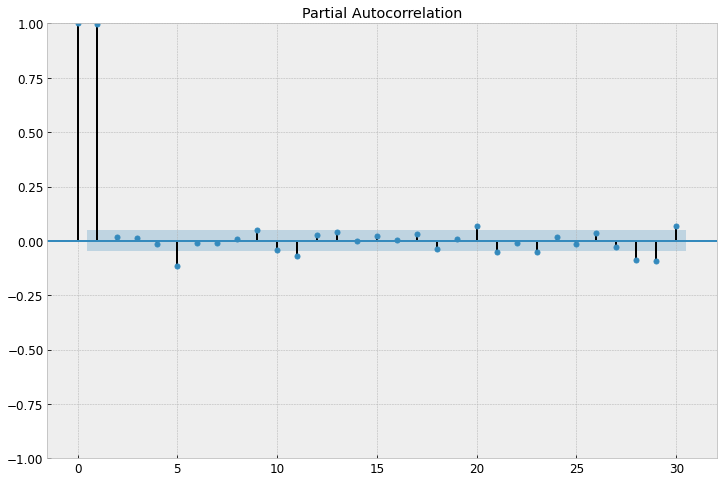

In [35]:
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()

In [ ]:
# Rolling means and standard deviation of our series


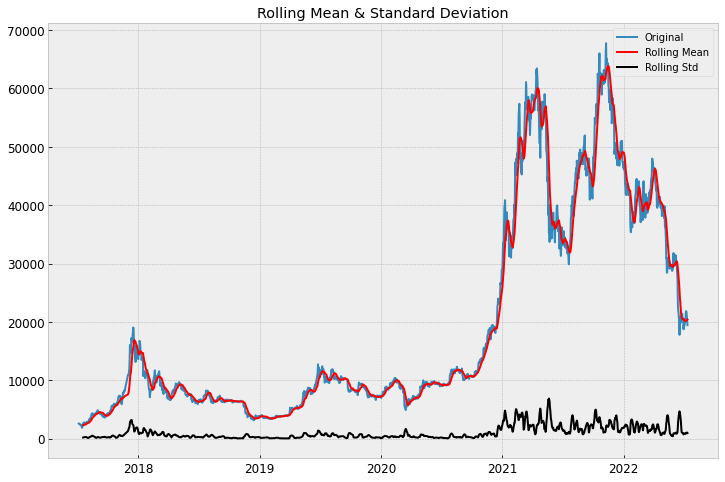

In [36]:
# Determing rolling statistics
rolmean = bf.XBTUSD.rolling(window=12).mean()
rolstd = bf.XBTUSD.rolling(window=12).std()

# Plot rolling statistics:
orig = plt.plot(bf.XBTUSD, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
# Augmented Dickey-Fuller test


In [37]:
X = bf.XBTUSD.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.476301
p-value: 0.545201
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


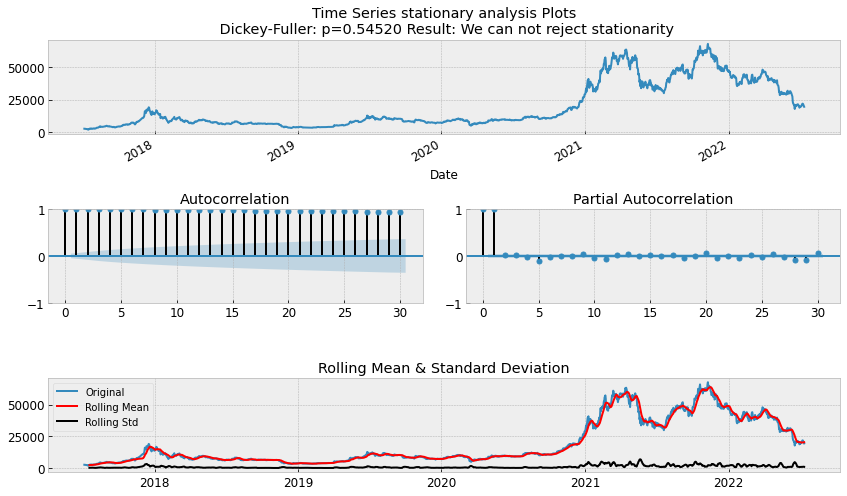

In [38]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value <= 0.05 else "We can not reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = bf.XBTUSD.rolling(window=12).mean()
        rolstd = bf.XBTUSD.rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(bf.XBTUSD, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(bf.XBTUSD, lags=30)

In [ ]:
# Making Time Series Stationary


Text(0.5, 1.0, 'Original vs Windowed mean vs Windowed std')

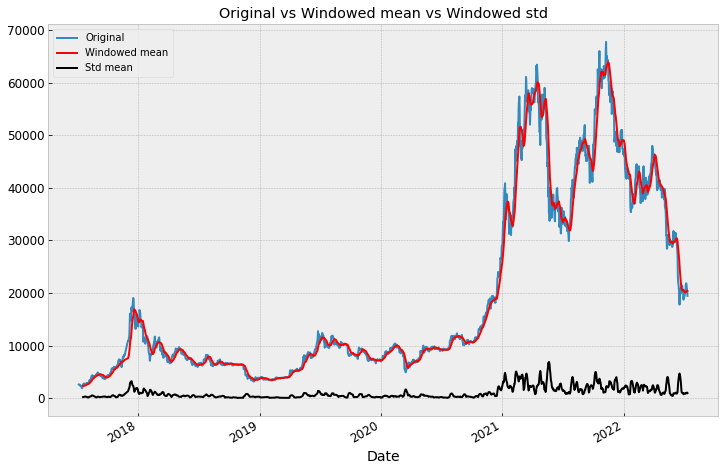

In [39]:
bf.XBTUSD.plot(label='Original')
bf.XBTUSD.rolling(window=12).mean().plot(
    color='red', label='Windowed mean')
bf.XBTUSD.rolling(window=12).std().plot(
    color='black', label='Std mean')
plt.legend()
plt.title('Original vs Windowed mean vs Windowed std')

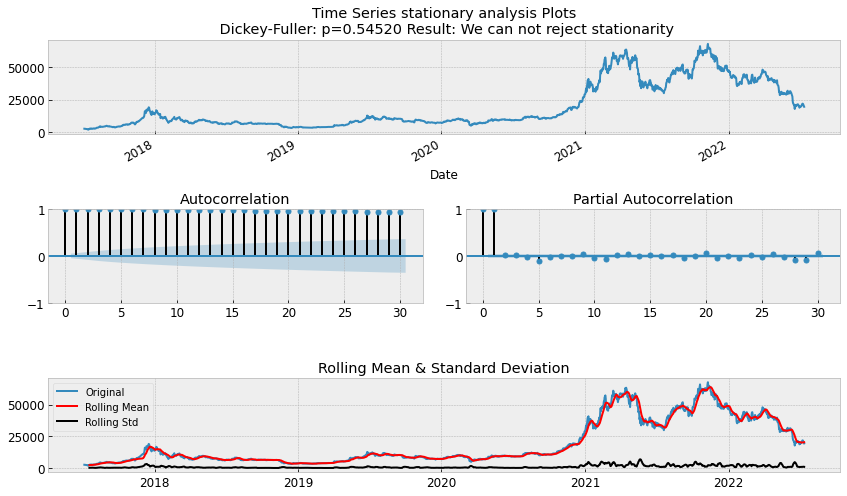

In [40]:
tsplot(bf.XBTUSD, lags=30)


In [41]:
def difference(dataset, interval=1, order=1):
    for u in range(order):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        dataset = diff
    return diff

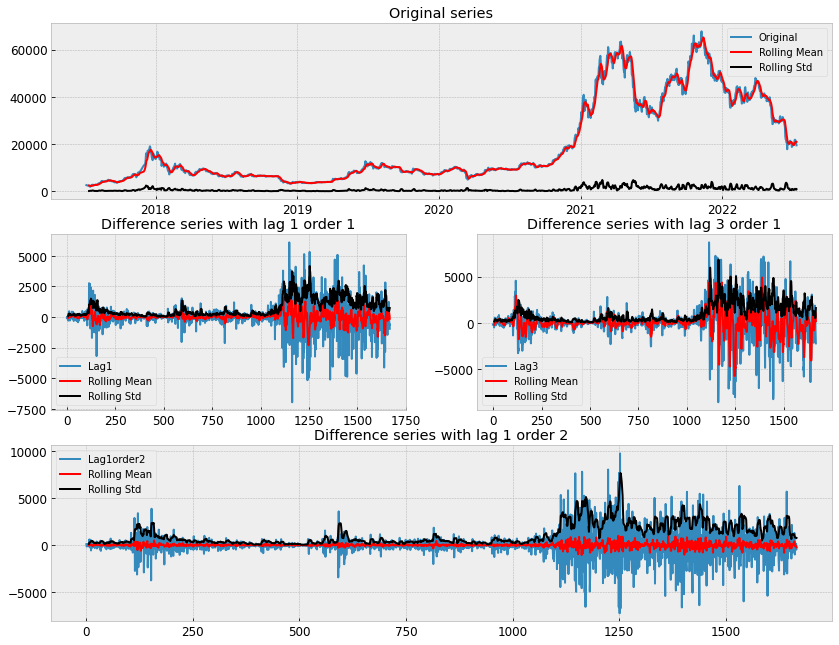

In [42]:
lag1series = pd.Series(difference(bf.XBTUSD, interval=1, order=1))
lag3series = pd.Series(difference(bf.XBTUSD, interval=3, order=1))
lag1order2series = pd.Series(difference(
    bf.XBTUSD, interval=1, order=2))

fig = plt.figure(figsize=(14, 11))
layout = (3, 2)
original = plt.subplot2grid(layout, (0, 0), colspan=2)
lag1 = plt.subplot2grid(layout, (1, 0))
lag3 = plt.subplot2grid(layout, (1, 1))
lag1order2 = plt.subplot2grid(layout, (2, 0), colspan=2)

original.set_title('Original series')
original.plot(bf.XBTUSD, label='Original')
original.plot(bf.XBTUSD.rolling(
    7).mean(), color='red', label='Rolling Mean')
original.plot(bf.XBTUSD.rolling(7).std(),
              color='black', label='Rolling Std')
original.legend(loc='best')

lag1.set_title('Difference series with lag 1 order 1')
lag1.plot(lag1series, label="Lag1")
lag1.plot(lag1series.rolling(7).mean(), color='red', label='Rolling Mean')
lag1.plot(lag1series.rolling(7).std(), color='black', label='Rolling Std')
lag1.legend(loc='best')

lag3.set_title('Difference series with lag 3 order 1')
lag3.plot(lag3series, label="Lag3")
lag3.plot(lag3series.rolling(7).mean(), color='red', label='Rolling Mean')
lag3.plot(lag3series.rolling(7).std(), color='black', label='Rolling Std')
lag3.legend(loc='best')

lag1order2.set_title('Difference series with lag 1 order 2')
lag1order2.plot(lag1order2series, label="Lag1order2")
lag1order2.plot(lag1order2series.rolling(7).mean(),
                color='red', label='Rolling Mean')
lag1order2.plot(lag1order2series.rolling(7).std(),
                color='black', label='Rolling Std')
lag1order2.legend(loc='best')

In [ ]:
# Log scale transformation


Text(0.5, 1.0, 'Log scale transformation into original series')

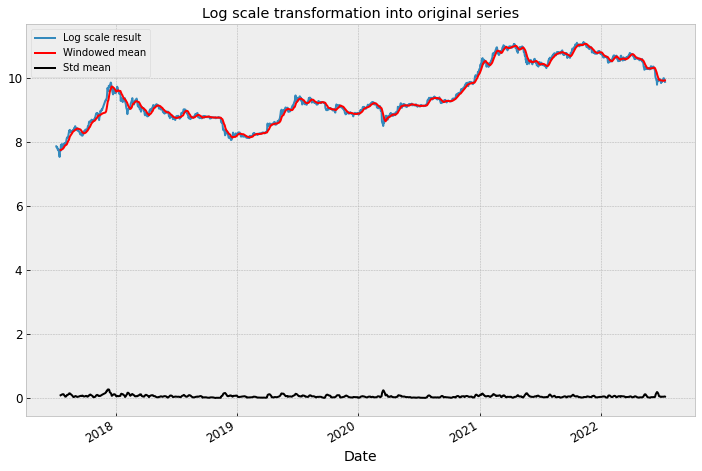

In [43]:
ts_log = np.log(bf.XBTUSD)
ts_log.plot(label='Log scale result')
ts_log.rolling(window=12).mean().plot(color='red', label='Windowed mean')
ts_log.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()
plt.title('Log scale transformation into original series')

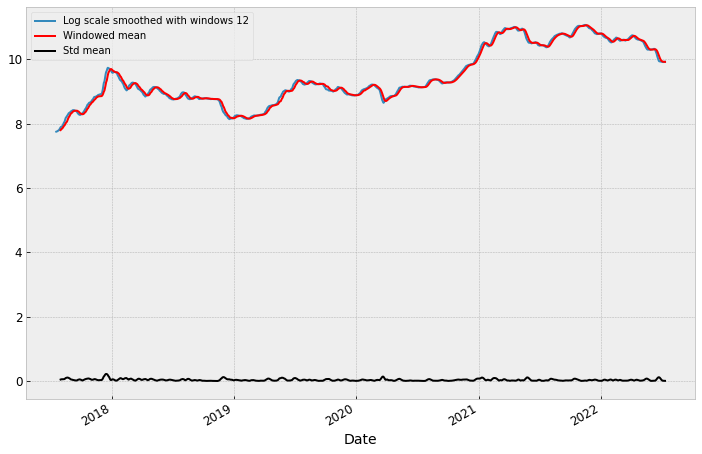

In [44]:
avg = pd.Series(ts_log).rolling(12).mean()
plt.plot(avg, label='Log scale smoothed with windows 12')
avg.rolling(window=12).mean().plot(color='red', label='Windowed mean')
avg.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()

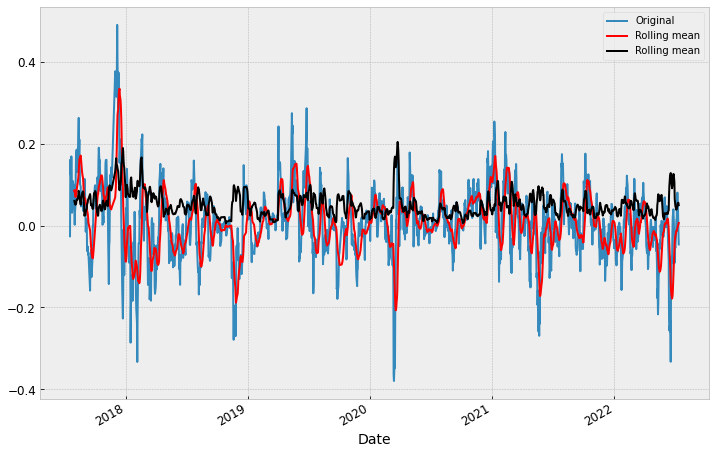

In [45]:
ts_log_moving_avg_diff = ts_log - avg

ts_log_moving_avg_diff.plot(label='Original')
ts_log_moving_avg_diff.rolling(12).mean().plot(
    color='red', label="Rolling mean")
ts_log_moving_avg_diff.rolling(12).std().plot(
    color='black', label="Rolling mean")
plt.legend(loc='best')

In [46]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_date = '2021-11-01'
df_training = bf.loc[bf.index <= split_date]
df_test = bf.loc[bf.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1416 days of training data 
 253 days of testing data 


In [47]:
train = bf[0:1416]
test = bf[1416:]

In [493]:
import numpy as np
from sklearn.metrics import r2_score

EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """Simple error"""
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """Naive forecasting method which just repeats previous samples"""
    return actual[:-seasonality]


def _relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) / (
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
            + EPSILON
        )

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Bounded Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
        )
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """Geometric mean"""
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """Mean Squared Error"""
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Root Mean Squared Error"""
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """Mean Error"""
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """Mean Absolute Error"""
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """Geometric Mean Absolute Error"""
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """Median Absolute Error"""
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """Mean Percentage Error"""
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Error"""
    __mae = mae(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted) - __mae)) / (len(actual) - 1)
    )


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Percentage Error"""
    __mape = mape(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_percentage_error(actual, predicted) - __mape))
        / (len(actual) - 1)
    )


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """Root Mean Squared Scaled Error"""
    q = np.abs(_error(actual, predicted)) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """Integral Normalized Root Squared Error"""
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted)))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """Root Relative Squared Error"""
    return np.sqrt(
        np.sum(np.square(actual - predicted))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Error"""
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """Relative Absolute Error (aka Approximation Error)"""
    return np.sum(np.abs(actual - predicted)) / (
        np.sum(np.abs(actual - np.mean(actual))) + EPSILON
    )


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Absolute Error"""
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Median Relative Absolute Error"""
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Geometric Mean Relative Absolute Error"""
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Bounded Relative Absolute Error"""
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Unscaled Mean Bounded Relative Absolute Error"""
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """Mean Directional Accuracy"""
    return np.mean(
        (
            np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])
        ).astype(int)
    )


def bias(actual: np.ndarray, predicted: np.ndarray):
    """Mean forecast error(or Forecast Bias)"""
    return np.mean(actual - predicted)


METRICS = {
    "mse": mse,
    "rmse": rmse,
    "nrmse": nrmse,
    "me": me,
    "mae": mae,
    "mad": mad,
    "gmae": gmae,
    "mdae": mdae,
    "mpe": mpe,
    "mape": mape,
    "mdape": mdape,
    "smape": smape,
    "smdape": smdape,
    "maape": maape,
    "mase": mase,
    "std_ae": std_ae,
    "std_ape": std_ape,
    "rmspe": rmspe,
    "rmdspe": rmdspe,
    "rmsse": rmsse,
    "inrse": inrse,
    "rrse": rrse,
    "mre": mre,
    "rae": rae,
    "mrae": mrae,
    "mdrae": mdrae,
    "gmrae": gmrae,
    "mbrae": mbrae,
    "umbrae": umbrae,
    "mda": mda,
    "bias": bias,
    "r2": r2_score,
}


def evaluate(
    actual: np.ndarray, predicted: np.ndarray, metrics=( "nrmse", "mape", "mdape", "smape", "smdape", "maape", "mase", "std_ae", "std_ape", "rmspe", "rmdspe", "rmsse", "inrse", "rrse", "mre", "rae", "mrae", "mdrae", "gmrae", "mbrae", "umbrae", "mda", "bias", "r2", "mse", "rmse", "me", "mae", "mad", "gmae", "mdae")
):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

In [494]:
#BAR METRICS
import matplotlib.pyplot as plt
import pandas as pd


def bar_metrics(resultsDict):
    df = pd.DataFrame.from_dict(resultsDict)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    pallette = plt.cm.get_cmap("tab20c", len(df.columns))
    colors = [pallette(x) for x in range(len(df.columns))]
    color_dict = dict(zip(df.columns, colors))
    fig = plt.figure(figsize=(20, 15))

    # MAE plot
    fig.add_subplot(2, 2, 1)
    df.loc["mae"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[color_dict.get(x, "#333333") for x in df.loc["mae"].sort_values().index],
    )
    plt.legend()
    plt.title("MAE Metric, lower is better")
    fig.add_subplot(2, 2, 2)
    df.loc["rmse"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["rmse"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("RMSE Metric, lower is better")
    fig.add_subplot(2, 2, 3)
    df.loc["mape"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["mape"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("MAPE Metric, lower is better")
    fig.add_subplot(2, 2, 4)
    df.loc["r2"].sort_values(ascending=False).plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333")
            for x in df.loc["r2"].sort_values(ascending=False).index
        ],
    )
    plt.legend()
    plt.title("R2 Metric, higher is better")
    plt.tight_layout()
    #plt.savefig("results/metrics.png")
    plt.show()

In [495]:
def evaluate(
    actual: np.ndarray, predicted: np.ndarray, metrics=("nrmse", "mape", "mdape", "smape", "smdape", "maape", "mase", "std_ae", "std_ape", "rmspe", "rmdspe", "rmsse", "inrse", "rrse", "mre", "rae", "mrae", "mdrae", "gmrae", "mbrae", "umbrae", "mda", "bias", "r2", "mse", "rmse", "me", "mae", "mad", "gmae", "mdae")
):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results



def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

In [51]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [ ]:
# Linear models
# 1.Bayesian regression


In [612]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_date = '2021-05-01'
df_training = bf.loc[bf.index <= split_date]
df_test = bf.loc[bf.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1232 days of training data 
 437 days of testing data 


In [613]:
train = bf[0:1232]
test = bf[1232:]

In [614]:
X_train_df, y_train = create_time_features(
    df_training, target='XBTUSD')
X_test_df, y_test = create_time_features(df_test, target='XBTUSD')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [615]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test.XBTUSD, yhat)
predictionsDict['BayesianRidge'] = yhat

Unable to compute metric mda: ('Lengths must match to compare', (437,), (436,))


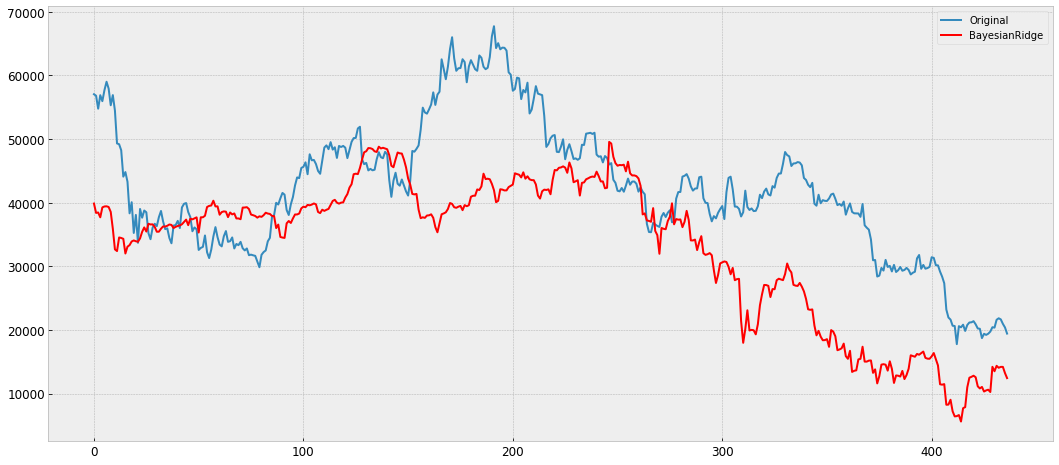

In [221]:
plt.plot(df_test.XBTUSD.values, label='Original')
plt.plot(yhat, color='red', label='BayesianRidge')
plt.legend()

In [209]:
resultsDict['BayesianRidge']

{'nrmse': 0.2550441389130652,
 'mape': 0.25989414996724053,
 'mdape': 0.2208689452651145,
 'smape': 0.3232707524217517,
 'smdape': 0.23705825137767159,
 'maape': 0.24643042420397118,
 'mase': inf,
 'std_ae': 9066.718665733106,
 'std_ape': 0.2329714271122288,
 'rmspe': 0.3178901013989407,
 'rmdspe': 0.2208689452651145,
 'rmsse': inf,
 'inrse': 1.197020253501436,
 'rrse': 1.197020253501436,
 'mre': 90580308000148.53,
 'rae': 1.2645693829694573,
 'mrae': 104891860959405.95,
 'mdrae': nan,
 'gmrae': nan,
 'mbrae': 0.9999999999999665,
 'umbrae': 29825163095167.848,
 'mda': nan,
 'bias': 9071.885697558528,
 'r2': -0.43285748729264206,
 'mse': 162286883.95244005,
 'rmse': 12739.186942361748,
 'me': 9071.885697558528,
 'mae': 10496.491083663099,
 'mad': 10496.491083663099,
 'gmae': 7190.917974533127,
 'mdae': 8531.797066265739}

In [ ]:
reg = linear_model.BayesianRidge()
bay_params = {'alpha_init':[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9],
              'lambda_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9]}
a = GridSearchCV(estimator=linear_model.BayesianRidge(), param_grid = bay_params, cv = 5, n_jobs=-1)
a.fit(X_train, y_train)
yhat = a.predict(X_test)
resultsDict['BayesianRidge Grid Search'] = evaluate(df_test.XBTUSD, yhat)
predictionsDict['BayesianRidge Grid Search'] = yhat

In [213]:
resultsDict['BayesianRidge Grid Search']

{'nrmse': 0.38057021871729524,
 'mape': 0.42262816844374806,
 'mdape': 0.3526704055991671,
 'smape': 0.6183404499903828,
 'smdape': 0.428172245308858,
 'maape': 0.3680633079445917,
 'mase': inf,
 'std_ae': 11824.102196733173,
 'std_ape': 0.37471372629796346,
 'rmspe': 0.5377134119427152,
 'rmdspe': 0.3526704055991671,
 'rmsse': inf,
 'inrse': 1.7861624330028354,
 'rrse': 1.7861624330028354,
 'mre': 149387663714237.66,
 'rae': 1.9405123252876637,
 'mrae': 161108050143460.66,
 'mdrae': nan,
 'gmrae': nan,
 'mbrae': 0.9999999999999543,
 'umbrae': 21862134113448.008,
 'mda': nan,
 'bias': 14940.44499899235,
 'r2': -2.1903762370706086,
 'mse': 361345229.893303,
 'rmse': 19009.082826199243,
 'me': 14940.44499899235,
 'mae': 16107.11962066558,
 'mad': 16107.11962066558,
 'gmae': 10745.928779228181,
 'mdae': 16815.346578566205}

In [214]:
predictionsDict['BayesianRidge Grid Search']

array([44784.31478806, 43286.5058536 , 43046.47080992, 42367.37621844,
       44952.33238091, 45274.21708511, 45208.45425156, 44976.84947098,
       43966.11362161, 40552.10472093, 36278.65685716, 35950.02718439,
       38233.39459195, 38029.64113672, 37814.5164032 , 35267.61580391,
       37007.47334882, 37352.03368236, 38282.96938855, 38378.29854022,
       38141.59142558, 38053.58059331, 38369.18016512, 39179.16968339,
       39734.04074356, 38454.65752619, 40197.98684733, 40049.58267814,
       40136.75471222, 39551.02875103, 36517.37775892, 36481.89008358,
       36774.09182298, 37080.94006992, 37098.63313942, 37322.83278798,
       37646.9635965 , 37352.64165363, 36514.6761226 , 36799.60756852,
       36887.56122993, 37067.39351935, 37323.02115649, 37696.15385143,
       38176.36364491, 37080.52556308, 37835.0522444 , 37627.3602767 ,
       37885.56957427, 38051.5568598 , 34410.21292494, 37326.06385898,
       37048.26792857, 37382.35467736, 38699.99521063, 38914.24249454,
      

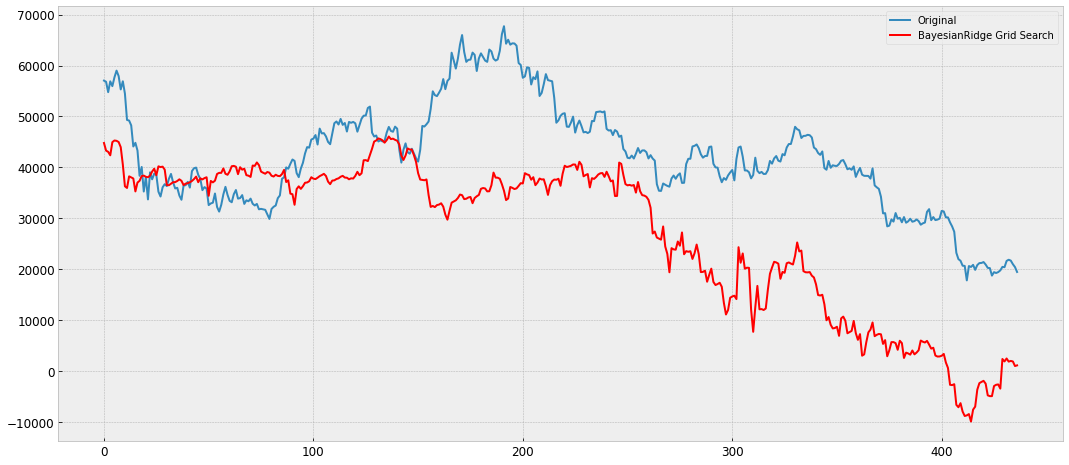

In [228]:
plt.plot(df_test.XBTUSD.values, label='Original')
plt.plot(yhat, color='red', label='BayesianRidge Grid Search')
plt.legend()

In [245]:
increase = 1 - (resultsDict['BayesianRidge Grid Search']
                ['r2']/resultsDict['BayesianRidge']['maape'])
print(
    f"Grid search Tunned BayesianRidge is {increase*100}% better than the BayesianRidge with default parameters")

Grid search Tunned BayesianRidge is 988.8416453229113% better than the BayesianRidge with default parameters


In [254]:
cv_results = pd.DataFrame(a.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha_init,param_lambda_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003618,0.000845,0.000646,0.000116,1,0.1,"{'alpha_init': 1, 'lambda_init': 0.1}",-29.458228,-5.664636,-10.03331,-84.200980,-0.488334,-25.969098,30.720078,48
1,0.006177,0.003076,0.000696,0.000107,1,0.01,"{'alpha_init': 1, 'lambda_init': 0.01}",-29.458228,-5.664636,-10.03331,-48.836675,-0.488334,-18.896237,17.891132,37
2,0.003543,0.000300,0.000647,0.000020,1,0.001,"{'alpha_init': 1, 'lambda_init': 0.001}",-29.458228,-5.664636,-10.03331,-48.836675,-0.488334,-18.896237,17.891132,35
3,0.004305,0.001710,0.000613,0.000035,1,0.0001,"{'alpha_init': 1, 'lambda_init': 0.0001}",-29.458228,-5.664636,-10.03331,-48.836675,-0.488334,-18.896237,17.891132,28
4,0.004889,0.002782,0.000661,0.000058,1,0.00001,"{'alpha_init': 1, 'lambda_init': 1e-05}",-29.458228,-5.664636,-10.03331,-48.836675,-0.488334,-18.896237,17.891132,21


In [255]:
y_pred = a.predict(X_test)


In [256]:
results = pd.DataFrame(zip(y_test, y_pred, y_test - y_pred), columns = ['y_test', 'y_pred', 'error'])
results.head(10)

,y_test,y_pred,error
0,57042.24,44784.314788,12257.925212
1,56811.66,43286.505854,13525.154146
2,54770.39,43046.470810,11723.919190
3,56895.44,42367.376218,14528.063782
4,55955.47,44952.332381,11003.137619
5,57684.39,45274.217085,12410.172915
6,59004.37,45208.454252,13795.915748
7,57931.38,44976.849471,12954.530529
8,55308.81,43966.113622,11342.696378
9,56911.32,40552.104721,16359.215279


In [ ]:
# 2.Lasso

In [395]:

resultsDict = {}
predictionsDict = {}

split_date = '2022-06-01'
df_training = bf.loc[bf.index <= split_date]
df_test = bf.loc[bf.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1628 days of training data 
 41 days of testing data 


In [396]:
train = bf[0:1628]
test = bf[1628:]

In [397]:
X_train_df, y_train = create_time_features(
    df_training, target='XBTUSD')
X_test_df, y_test = create_time_features(df_test, target='XBTUSD')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [554]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Lasso'] = evaluate(df_test.XBTUSD, yhat)
predictionsDict['Lasso'] = yhat

Unable to compute metric mda: ('Lengths must match to compare', (11,), (10,))


In [399]:
resultsDict['Lasso']

{'nrmse': 0.3958087890921181,
 'mape': 0.21324513218390584,
 'mdape': 0.23509659063205682,
 'smape': 0.1837646899459169,
 'smdape': 0.2103681707693671,
 'maape': 0.20550675622899267,
 'mase': inf,
 'std_ae': 9486.981771253031,
 'std_ape': 0.45865218462074325,
 'rmspe': 0.26383473397686935,
 'rmdspe': 0.23509659063205682,
 'rmsse': inf,
 'inrse': 1.2795645832361568,
 'rrse': 1.2795645832361568,
 'mre': -43603304994619.16,
 'rae': 1.2240454710577269,
 'mrae': 44180433535200.7,
 'mdrae': nan,
 'gmrae': nan,
 'mbrae': 0.9999999999998778,
 'umbrae': 8180925753623.879,
 'mda': nan,
 'bias': -4383.16668374891,
 'r2': -0.63728552267232,
 'mse': 29205666.841202457,
 'rmse': 5404.2267570118165,
 'me': -4383.16668374891,
 'mae': 4438.064276633497,
 'mad': 4438.064276633497,
 'gmae': 2770.426682713038,
 'mdae': 4181.214023084311}

In [400]:
y_pred = reg.predict(X_test)


In [404]:
results = pd.DataFrame(zip(y_test, y_pred, y_test - y_pred), columns = ['y_test', 'y_pred', 'error'])
results.head(10)

,y_test,y_pred,error
0,30225.18,32633.737927,-2408.557927
1,29640.50,31253.118372,-1612.618372
2,29733.76,31085.962086,-1352.202086
3,29925.66,30988.919070,-1063.259070
4,31438.72,31294.271118,144.448882
5,31330.81,32247.266062,-916.456062
6,30179.77,31339.211647,-1159.441647
7,30161.34,30212.616680,-51.276680
8,29177.39,28353.144013,824.245987
9,28380.38,28223.674214,156.705786


In [305]:
resultsDict['Lasso']

{'nrmse': 0.20497932878482827,
 'mape': 0.14107942313485508,
 'mdape': 0.12293389303055403,
 'smape': 0.136300047859266,
 'smdape': 0.12982526016320575,
 'maape': 0.13867861000980583,
 'mase': inf,
 'std_ae': 8441.618678419953,
 'std_ape': 0.23927334410518314,
 'rmspe': 0.17272587541111398,
 'rmdspe': 0.12293396805246731,
 'rmsse': inf,
 'inrse': 0.755431487404311,
 'rrse': 0.755431487404311,
 'mre': -8134590851402.276,
 'rae': 0.7066078993756519,
 'mrae': 49117372526447.62,
 'mdrae': nan,
 'gmrae': nan,
 'mbrae': 0.9999999999975617,
 'umbrae': 410126548343.45825,
 'mda': nan,
 'bias': -859.7981543372716,
 'r2': 0.42932326783811037,
 'mse': 38276276.98053412,
 'rmse': 6186.782441668215,
 'me': -859.7981543372716,
 'mae': 4915.3859242636345,
 'mad': 4915.3859242636345,
 'gmae': 3258.7984045016215,
 'mdae': 3919.3603560155716}

In [465]:
from sklearn.linear_model import ElasticNet


In [466]:

# set up cross validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
params = {'alpha': [0.001, 0.01, 1.0, 5.0, 10.0]}

# grid search
# lasso model
model = ElasticNet()
model_cv_en = GridSearchCV(estimator = model, param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True, verbose = 1)            
model_cv_en.fit(X_train, y_train) 

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=ElasticNet(),
             param_grid={'alpha': [0.001, 0.01, 1.0, 5.0, 10.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [467]:
yhat = model_cv_en.predict(X_test)
resultsDict['Lasso Grid Search'] = evaluate(df_test.XBTUSD, yhat)
predictionsDict['Lasso Grid Search'] = yhat

Unable to compute metric mda: ('Lengths must match to compare', (11,), (10,))


In [324]:
resultsDict['Lasso Grid Search']

{'nrmse': 0.20436178485218404,
 'mape': 0.14053593759081284,
 'mdape': 0.11596615235914845,
 'smape': 0.13411480842604576,
 'smdape': 0.12066464793218427,
 'maape': 0.1380074592499008,
 'mase': inf,
 'std_ae': 8592.423922151862,
 'std_ape': 0.24706986511836967,
 'rmspe': 0.17439332984252537,
 'rmdspe': 0.11596619468608399,
 'rmsse': inf,
 'inrse': 0.7531555889791354,
 'rrse': 0.7531555889791354,
 'mre': -11405658558410.729,
 'rae': 0.7017338882563826,
 'mrae': 48758263921096.24,
 'mdrae': nan,
 'gmrae': nan,
 'mbrae': 0.999999999999935,
 'umbrae': 15396921802975.055,
 'mda': nan,
 'bias': -1185.1292035691501,
 'r2': 0.43275665878949177,
 'mse': 38045993.501935504,
 'rmse': 6168.1434404474985,
 'me': -1185.1292035691501,
 'mae': 4881.480775918238,
 'mad': 4881.480775918238,
 'gmae': 3351.622440846019,
 'mdae': 3932.1178752768974}

In [325]:
predictionsDict['Lasso Grid Search']

array([51717.11561054, 60435.08549013, 59829.03678281, 56957.67291751,
       56744.35256476, 56212.35105829, 56356.85774929, 56335.57124582,
       57161.32093965, 56792.97517238, 57638.45644634, 55314.34278369,
       55750.15189586, 55783.53976384, 55634.83714098, 55054.272453  ,
       53371.52519855, 49427.06025675, 48458.88137632, 46983.9055119 ,
       46880.91434095, 46669.1595014 , 48916.17723603, 45488.09224353,
       44678.93215752, 42302.7402384 , 46744.04853172, 46546.54325401,
       46367.13411723, 48331.000595  , 49037.41516278, 50951.11759461,
       47239.37373101, 48562.4861855 , 48358.85115041, 48291.26522681,
       46908.51455283, 48106.5863174 , 49880.64134744, 47714.51280704,
       44212.63624526, 44094.27284111, 44162.94875974, 43149.92838906,
       45246.19897137, 45787.77765291, 42639.21172714, 42525.88826174,
       42542.22756457, 42704.53649009, 43056.35120281, 40740.99176179,
       38398.62798249, 40307.24528597, 42156.63990247, 42290.81292329,
      

In [468]:
cv_results_en = pd.DataFrame(model_cv_en.cv_results_)
cv_results_en.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.022735,0.002453,0.000902,0.000036,0.001,{'alpha': 0.001},0.861575,0.876446,0.882925,0.873766,...,0.875883,0.008209,1,0.882249,0.878723,0.877312,0.879286,0.876503,0.878815,0.001981
1,0.023697,0.005203,0.000951,0.000180,0.01,{'alpha': 0.01},0.860100,0.871598,0.880986,0.871994,...,0.873307,0.007889,2,0.879529,0.876327,0.874635,0.876629,0.873770,0.876178,0.001982
2,0.002683,0.000882,0.000648,0.000046,1.0,{'alpha': 1.0},0.841466,0.842371,0.857397,0.853671,...,0.850119,0.006804,3,0.853688,0.853004,0.849872,0.851338,0.849628,0.851506,0.001627
3,0.001954,0.000140,0.000649,0.000024,5.0,{'alpha': 5.0},0.768461,0.766523,0.785465,0.781213,...,0.776362,0.007483,4,0.780233,0.778541,0.775057,0.778496,0.774753,0.777416,0.002146
4,0.001822,0.000071,0.000628,0.000016,10.0,{'alpha': 10.0},0.668224,0.664840,0.683373,0.680121,...,0.674595,0.007024,5,0.679341,0.676173,0.672596,0.678622,0.672437,0.675834,0.002905


In [326]:
increase = 1 - (resultsDict['Lasso Grid Search']
                ['r2']/resultsDict['Lasso']['mse'])
print(
    f"Grid search Tunned Lasso is {increase*100}% better than the Lasso with default parameters")

Grid search Tunned Lasso is 99.99999886938676% better than the Lasso with default parameters


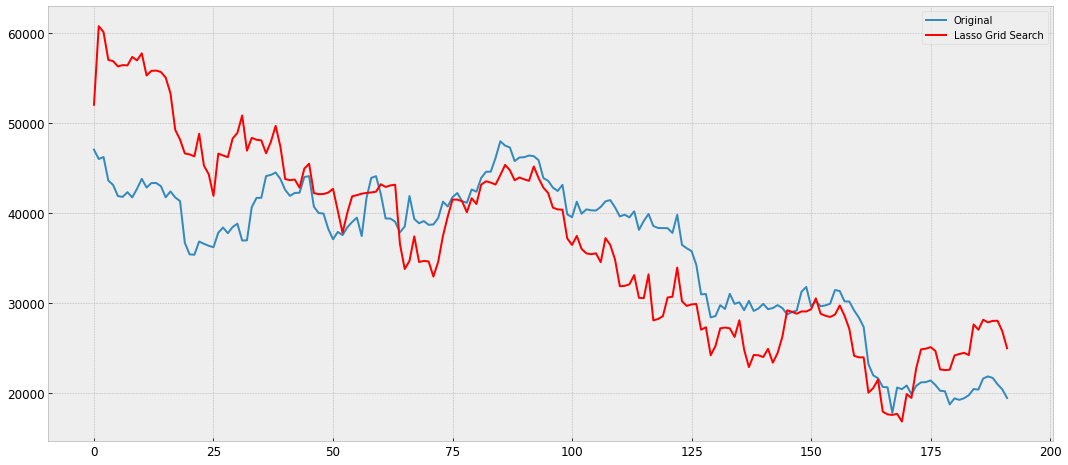

In [312]:
plt.plot(df_test.XBTUSD.values, label='Original')
plt.plot(yhat, color='red', label='Lasso Grid Search')
plt.legend()

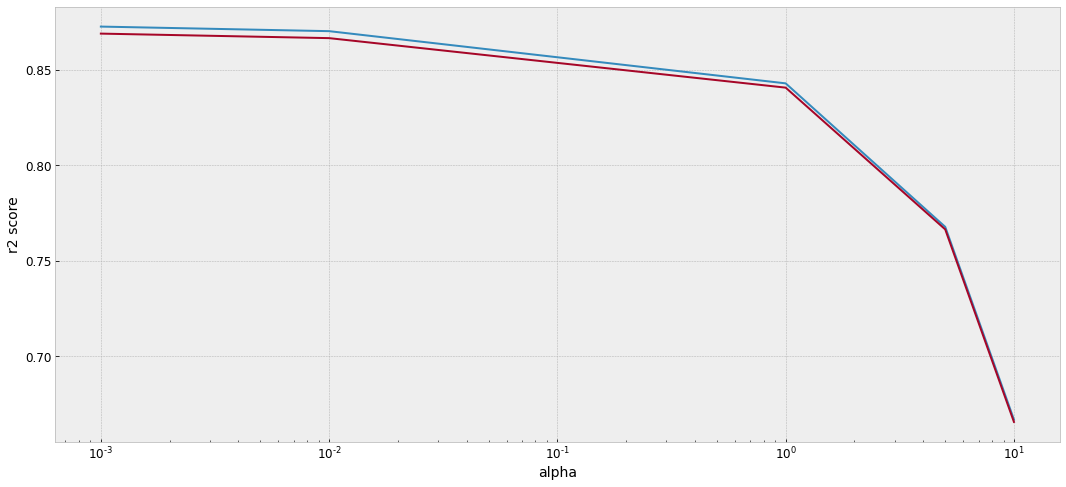

In [330]:
# plot
cv_results_en['param_alpha'] = cv_results_en['param_alpha'].astype('float32')
plt.plot(cv_results_en['param_alpha'], cv_results_en['mean_train_score'])
plt.plot(cv_results_en['param_alpha'], cv_results_en['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.xscale('log')
plt.show()

In [ ]:
# 2.XGBoost

In [532]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_date = '2022-07-01'
df_training = bf.loc[bf.index <= split_date]
df_test = bf.loc[bf.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1658 days of training data 
 11 days of testing data 


In [533]:
train = bf[0:1658]
test = bf[1658:]

In [534]:
X_train_df, y_train = create_time_features(
    df_training, target='XBTUSD')
X_test_df, y_test = create_time_features(df_test, target='XBTUSD')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [535]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.XBTUSD, yhat)
predictionsDict['XGBoost'] = yhat

Unable to compute metric mda: ('Lengths must match to compare', (11,), (10,))


In [414]:
resultsDict['XGBoost']

{'nrmse': 0.4590246592751235,
 'mape': 0.051702506394280826,
 'mdape': 0.0381667803460746,
 'smape': 0.0500230768257952,
 'smdape': 0.037452067921148316,
 'maape': 0.05160770240079628,
 'mase': inf,
 'std_ae': 2273.0599586730473,
 'std_ape': 0.11190407298675939,
 'rmspe': 0.05920970910976082,
 'rmdspe': 0.0381667803460746,
 'rmsse': inf,
 'inrse': 1.3167304437880514,
 'rrse': 1.3167304437880514,
 'mre': -9176340017361.111,
 'rae': 1.3734518543711318,
 'mrae': 9517323350694.447,
 'mdrae': nan,
 'gmrae': nan,
 'mbrae': 0.9999999999998312,
 'umbrae': 5925788983381.231,
 'mda': nan,
 'bias': -1024.5886434659092,
 'r2': -0.7337790615982787,
 'mse': 1432629.8387517512,
 'rmse': 1196.9251600462542,
 'me': -1024.5886434659092,
 'mae': 1052.4872798295457,
 'mad': 1052.4872798295457,
 'gmae': 873.3575081267268,
 'mdae': 822.1602343749983}

In [542]:
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [543]:
xgb_grid.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = xgb_grid.predict(X_test)
resultsDict['XGBoost Grid Search'] = evaluate(df_test.XBTUSD, yhat)
predictionsDict['XGBoost Grid Search'] = yhat

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Unable to compute metric mda: ('Lengths must match to compare', (11,), (10,))


In [544]:
resultsDict['XGBoost Grid Search']

{'nrmse': 0.3778979242234186,
 'mape': 0.039030671957630034,
 'mdape': 0.03268966454872852,
 'smape': 0.03986783168562575,
 'smdape': 0.032163950177791584,
 'maape': 0.03898459438976402,
 'mase': inf,
 'std_ae': 1003.9403242965491,
 'std_ape': 0.04822344526455726,
 'rmspe': 0.046223516580168746,
 'rmdspe': 0.03268966454872852,
 'rmsse': inf,
 'inrse': 1.0840151861450373,
 'rrse': 1.0840151861450373,
 'mre': 6334892621527.777,
 'rae': 1.066110344335845,
 'mrae': 9052132378472.227,
 'mdrae': nan,
 'gmrae': nan,
 'mbrae': 0.9999999999972401,
 'umbrae': 362331519961.2266,
 'mda': nan,
 'bias': 441.9694176136363,
 'r2': -0.17508892379305996,
 'mse': 970981.535479337,
 'rmse': 985.3839533295319,
 'me': 441.9694176136363,
 'mae': 816.968991477273,
 'mad': 816.968991477273,
 'gmae': 477.76896583476844,
 'mdae': 645.8121093750015}

In [545]:
predictionsDict['XGBoost Grid Search'] 

array([19551.555, 19993.23 , 20401.662, 20010.127, 20384.195, 20233.543,
       20025.434, 19986.295, 20059.969, 19714.602, 19970.455],
      dtype=float32)

In [546]:
increase = 1 - (resultsDict['XGBoost Grid Search']
                ['r2']/resultsDict['XGBoost']['mse'])
print(
    f"Grid search Tunned XGBoost is {increase*100}% better than the XGBoost with default parameters")

Grid search Tunned XGBoost is 100.00001222150475% better than the XGBoost with default parameters


In [510]:
from sklearn.model_selection import GridSearchCV


In [513]:
cv_results_en = pd.DataFrame(xgb_grid.cv_results_)
cv_results_en.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_nthread,param_objective,param_silent,param_subsample,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,3.324943,0.382742,0.061432,0.016039,0.7,0.03,5,4,500,4,reg:linear,1,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",-4.391419,-1.818484,-3.104952,1.286467,2
1,4.406768,0.290704,0.083851,0.000682,0.7,0.03,6,4,500,4,reg:linear,1,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",-4.624899,-1.826143,-3.225521,1.399378,5
2,5.425863,0.024497,0.093892,0.002991,0.7,0.03,7,4,500,4,reg:linear,1,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",-4.572962,-1.844407,-3.208684,1.364277,4
3,3.734269,0.097843,0.063164,0.005730,0.7,0.05,5,4,500,4,reg:linear,1,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",-4.968441,-1.842512,-3.405476,1.562964,8
4,4.945522,0.001092,0.067836,0.003898,0.7,0.05,6,4,500,4,reg:linear,1,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",-4.321364,-1.847796,-3.084580,1.236784,1


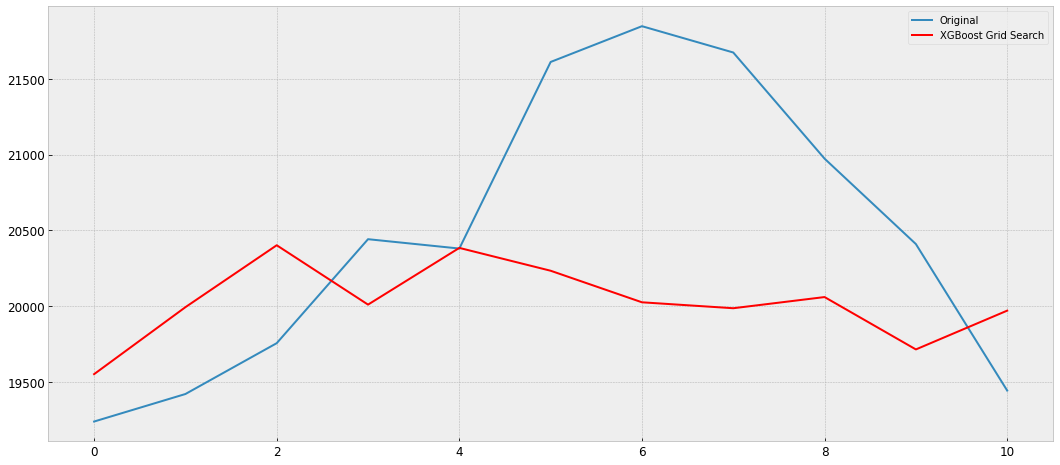

In [554]:
plt.plot(df_test.XBTUSD.values, label='Original')
plt.plot(yhat, color='red', label='XGBoost Grid Search')
plt.legend()

In [459]:
y_pred = model.predict(X_test)


In [460]:
results = pd.DataFrame(zip(y_test, y_pred, y_test - y_pred), columns = ['y_test', 'y_pred', 'error'])
results.head(10)

,y_test,y_pred,error
0,19238.99,18842.056641,396.933359
1,19420.48,19516.580078,-96.100078
2,19755.85,20005.070312,-249.220313
3,20441.63,19546.820312,894.809688
4,20380.00,19984.925781,395.074219
5,21610.58,19687.035156,1923.544844
6,21846.53,19759.302734,2087.227266
7,21672.98,19757.646484,1915.333516
8,20972.87,19869.626953,1103.243047
9,20409.54,19908.105469,501.434531


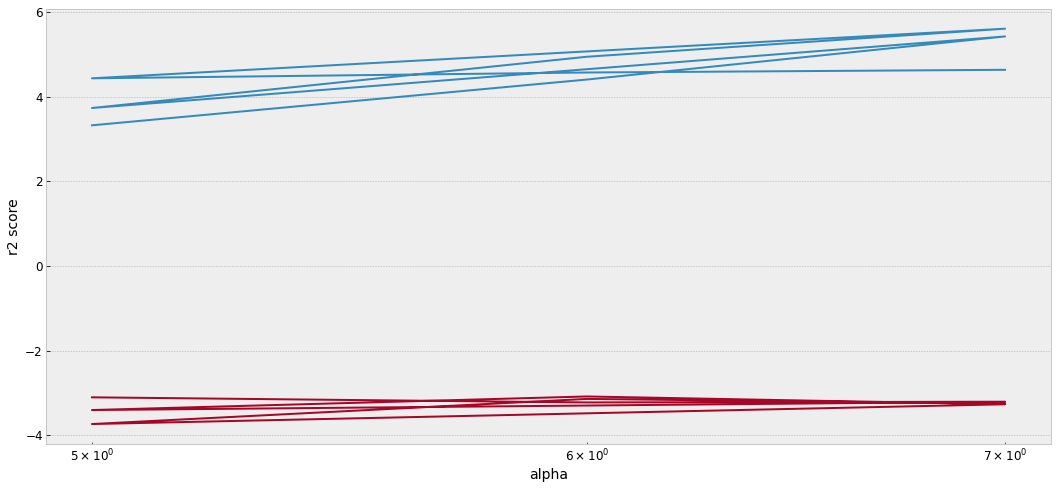

In [523]:
# plot
cv_results_en['param_max_depth'] = cv_results_en['param_max_depth'].astype('float32')
plt.plot(cv_results_en['param_max_depth'], cv_results_en['mean_fit_time'])
plt.plot(cv_results_en['param_max_depth'], cv_results_en['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.xscale('log')
plt.show()

In [ ]:
# Lightgbm

In [524]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_date = '2022-07-01'
df_training = bf.loc[bf.index <= split_date]
df_test = bf.loc[bf.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1658 days of training data 
 11 days of testing data 


In [525]:
train = bf[0:1658]
test = bf[1658:]

In [526]:
X_train_df, y_train = create_time_features(
    df_training, target='XBTUSD')
X_test_df, y_test = create_time_features(df_test, target='XBTUSD')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [536]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test.XBTUSD, yhat)
predictionsDict['Lightgbm'] = yhat

Unable to compute metric mda: ('Lengths must match to compare', (11,), (10,))


In [528]:
resultsDict['Lightgbm']

{'nrmse': 0.35344401117025154,
 'mape': 0.038340375993103464,
 'mdape': 0.027394647459823812,
 'smape': 0.0373375106080931,
 'smdape': 0.02702448434906085,
 'maape': 0.03829282492998699,
 'mase': inf,
 'std_ae': 1616.8032392934929,
 'std_ape': 0.08183548241176901,
 'rmspe': 0.04684758214734722,
 'rmdspe': 0.027394647459823812,
 'rmsse': inf,
 'inrse': 1.0138681665106262,
 'rrse': 1.0138681665106262,
 'mre': -4343654221952.068,
 'rae': 0.9969690166839358,
 'mrae': 6135363582250.931,
 'mdrae': nan,
 'gmrae': nan,
 'mbrae': 0.9999999999995948,
 'umbrae': 2467725823215.71,
 'mda': nan,
 'bias': -617.3910299037314,
 'r2': -0.027928659063618744,
 'mse': 849382.3127181305,
 'rmse': 921.6193968868768,
 'me': -617.3910299037314,
 'mae': 763.9854321100019,
 'mad': 763.9854321100019,
 'gmae': 520.7783732637629,
 'mdae': 558.302915231212}

In [529]:
predictionsDict['Lightgbm']

array([20723.52490695, 20863.10253301, 20805.08510469, 20525.88761646,
       20938.30291523, 21403.76266372, 21333.54029352, 21586.51783063,
       21516.30319845, 21447.24664404, 20840.75762223])

In [533]:
from sklearn.model_selection import GridSearchCV
estimator = lgb.LGBMRegressor()

In [534]:
# All parameters must be within square brackets (as a list)
params = {
    'boosting_type': ['rf'],
    'objective': ['regression'],
    'metric': ['rmse'],
    'max_bin':[50],
    'min_data_in_leaf':[5,7],
    'num_leaves': [31],
    'max_depth': [8],
    'lambda': [0.1],
    'path_smooth': [1.25],
    'learning_rate': [0.01,0.05,0.09],
    'feature_fraction': [0.5,0.6,0.7],
    'bagging_fraction': [0.6,0.7],
    'bagging_freq': [2],
    'verbose': [0]
}

In [535]:
# Grid Search to find the best parameters
gbm = GridSearchCV(estimator, params)
gbm.fit(X_train, y_train)

GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'bagging_fraction': [0.6, 0.7], 'bagging_freq': [2],
                         'boosting_type': ['rf'],
                         'feature_fraction': [0.5, 0.6, 0.7], 'lambda': [0.1],
                         'learning_rate': [0.01, 0.05, 0.09], 'max_bin': [50],
                         'max_depth': [8], 'metric': ['rmse'],
                         'min_data_in_leaf': [5, 7], 'num_leaves': [31],
                         'objective': ['regression'], 'path_smooth': [1.25],
                         'verbose': [0]})

In [ ]:
yhat = gbm.predict(X_test)
resultsDict['Lightgbm Grid Search'] = evaluate(df_test.XBTUSD, yhat)
predictionsDict['Lightgbm Grid Search'] = yhat

In [557]:
resultsDict['Lightgbm Grid Search']

{'nrmse': 0.40241039843565507,
 'mape': 0.0431643631662501,
 'mdape': 0.025642679530727196,
 'smape': 0.04182843962899543,
 'smdape': 0.025318067978966356,
 'maape': 0.04308726457181431,
 'mase': inf,
 'std_ae': 1830.0570153214296,
 'std_ape': 0.09299826131073588,
 'rmspe': 0.05365910905282832,
 'rmdspe': 0.025642679530727196,
 'rmsse': inf,
 'inrse': 1.154330190787252,
 'rrse': 1.154330190787252,
 'mre': -4855650531315.966,
 'rae': 1.1188443079960833,
 'mrae': 6720869666795.862,
 'mdrae': nan,
 'gmrae': nan,
 'mbrae': 0.9999999999997721,
 'umbrae': 4387335243418.8696,
 'mda': nan,
 'bias': -704.7706165741918,
 'r2': -0.33247818936293383,
 'mse': 1101033.030014498,
 'rmse': 1049.301210336907,
 'me': -704.7706165741918,
 'mae': 857.3794549316378,
 'mad': 857.3794549316378,
 'gmae': 656.3591313723298,
 'mdae': 523.3552935895605}

In [558]:
predictionsDict['Lightgbm Grid Search']

array([21159.63158996, 21159.63158996, 21138.58824446, 20901.26493655,
       20977.51888481, 21330.93110947, 21479.90513978, 21479.90513978,
       21479.90513978, 20932.89529359, 20905.02971417])

In [566]:
increase = 1 - (resultsDict['Lightgbm Grid Search']
                ['me']/resultsDict['Lightgbm']['mae'])
print(
    f"Grid search Tunned Lightgbm is {increase*100}% better than the Lightgbm with default parameters")

Grid search Tunned Lightgbm is 192.24922190305796% better than the Lightgbm with default parameters


In [567]:
cv_results_en = pd.DataFrame(gbm.cv_results_)
cv_results_en.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bagging_fraction,param_bagging_freq,param_boosting_type,param_feature_fraction,param_lambda,param_learning_rate,...,param_verbose,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.116311,0.004248,0.004547,0.003243,0.6,2,rf,0.5,0.1,0.01,...,0,"{'bagging_fraction': 0.6, 'bagging_freq': 2, '...",-0.112899,-0.443539,-1.412747,0.229596,-0.769900,-0.501898,0.564142,1
1,0.110911,0.006361,0.002910,0.000159,0.6,2,rf,0.5,0.1,0.01,...,0,"{'bagging_fraction': 0.6, 'bagging_freq': 2, '...",-0.119003,-0.416354,-1.593095,0.223469,-0.835871,-0.548171,0.627953,10
2,0.117597,0.004362,0.002861,0.000104,0.6,2,rf,0.5,0.1,0.05,...,0,"{'bagging_fraction': 0.6, 'bagging_freq': 2, '...",-0.112899,-0.443539,-1.412747,0.229596,-0.769900,-0.501898,0.564142,1
3,0.115543,0.003876,0.002912,0.000159,0.6,2,rf,0.5,0.1,0.05,...,0,"{'bagging_fraction': 0.6, 'bagging_freq': 2, '...",-0.119003,-0.416354,-1.593095,0.223469,-0.835871,-0.548171,0.627953,10
4,0.094509,0.022555,0.002675,0.000562,0.6,2,rf,0.5,0.1,0.09,...,0,"{'bagging_fraction': 0.6, 'bagging_freq': 2, '...",-0.112899,-0.443539,-1.412747,0.229596,-0.769900,-0.501898,0.564142,1


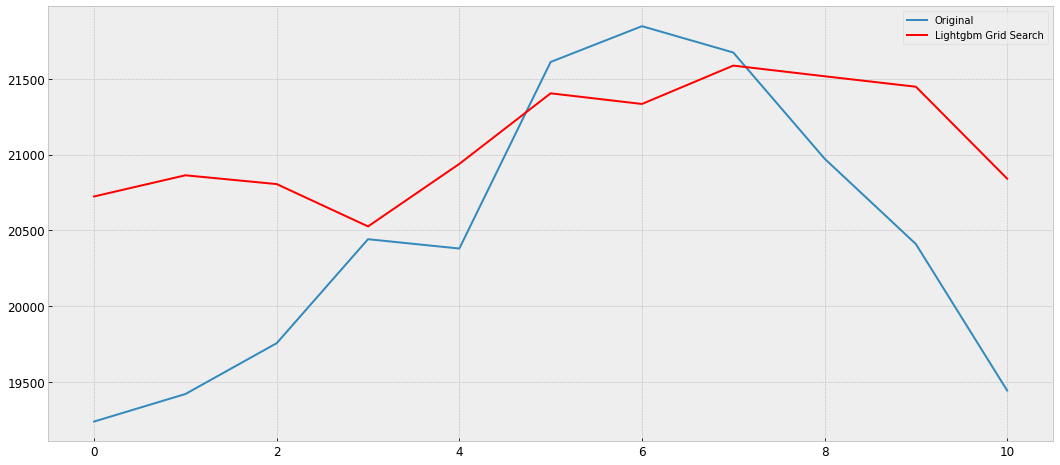

In [568]:
plt.plot(df_test.XBTUSD.values, label='Original')
plt.plot(yhat, color='red', label='Lightgbm Grid Search')
plt.legend()

In [570]:
y_pred = gbm.predict(X_test)


In [571]:
results = pd.DataFrame(zip(y_test, y_pred, y_test - y_pred), columns = ['y_test', 'y_pred', 'error'])
results.head(10)

,y_test,y_pred,error
0,19238.99,21159.631590,-1920.641590
1,19420.48,21159.631590,-1739.151590
2,19755.85,21138.588244,-1382.738244
3,20441.63,20901.264937,-459.634937
4,20380.00,20977.518885,-597.518885
5,21610.58,21330.931109,279.648891
6,21846.53,21479.905140,366.624860
7,21672.98,21479.905140,193.074860
8,20972.87,21479.905140,-507.035140
9,20409.54,20932.895294,-523.355294


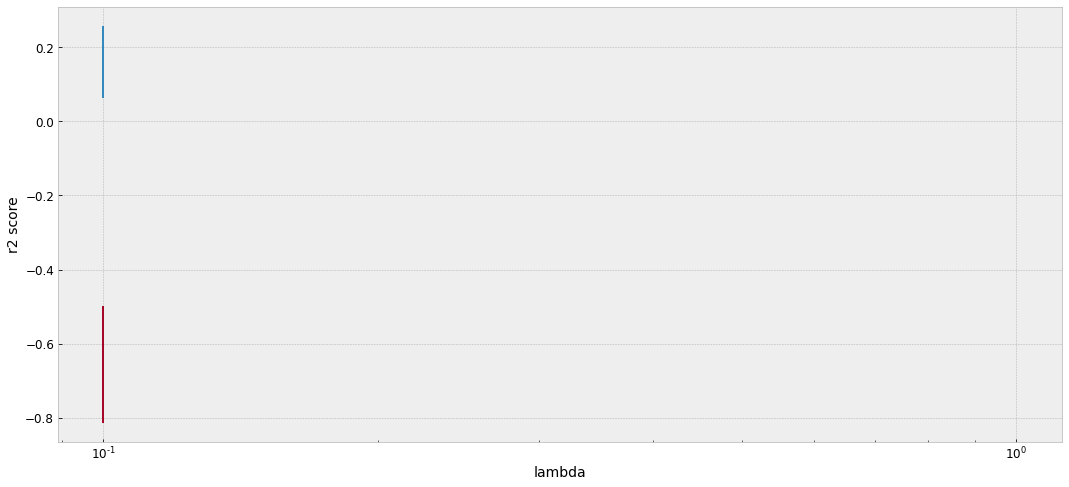

In [575]:
# plot
cv_results_en['split4_test_score'] = cv_results_en['param_lambda'].astype('float32')
plt.plot(cv_results_en['split4_test_score'], cv_results_en['mean_fit_time'])
plt.plot(cv_results_en['split4_test_score'], cv_results_en['mean_test_score'])
plt.xlabel('lambda')
plt.ylabel('r2 score')
plt.xscale('log')
plt.show()

In [ ]:
# Prophet multivariate


In [330]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_date = '2022-07-01'
df_training = bf.loc[bf.index <= split_date]
df_test = bf.loc[bf.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1658 days of training data 
 11 days of testing data 


In [331]:
train = bf[0:1628]
test = bf[1628:]

In [332]:
X_train_df, y_train = create_time_features(
    df_training, target='XBTUSD')
X_test_df, y_test = create_time_features(df_test, target='XBTUSD')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [555]:
# Prophet needs some specifics data stuff, coment it here
prophet_training = df_training.rename(
    columns={'XBTUSD': 'y'})  # old method
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = df_test.rename(columns={'XBTUSD': 'y'})  # old method
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [556]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    daily_seasonality=True,
).add_country_holidays(country_name='China')


for col in prophet_training.columns:
    if col not in ["ds", "y"]:
        prophet.add_regressor(col)

In [335]:
#Grid Search Parameter Tuning
import numpy as np
from sklearn import datasets
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# datasets
dataset = np.random.rand(1000,2)

#Ridge regression 
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid.fit(X_train, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])})

In [557]:

yhat = grid.predict(X_test)
resultsDict['Prophet multivariate GridSearchCV'] = evaluate(df_test.XBTUSD, yhat)
predictionsDict['Prophet multivariate GridSearchCV'] = yhat

Unable to compute metric mda: ('Lengths must match to compare', (11,), (10,))


In [220]:
resultsDict['Prophet multivariate GridSearchCV']

{'nrmse': 0.7868711330947273,
 'mape': 0.09429143343285697,
 'mdape': 0.09489877240508413,
 'smape': 0.0983757526741623,
 'smdape': 0.09962596320919782,
 'maape': 0.09394461451726964,
 'mase': inf,
 'std_ae': 1782.453523282814,
 'std_ape': 0.0873107953647021,
 'rmspe': 0.09822095618390701,
 'rmdspe': 0.09489877240508413,
 'rmsse': inf,
 'inrse': 2.257171059001487,
 'rrse': 2.257171059001487,
 'mre': 15671937442176.996,
 'rae': 2.545236233676762,
 'mrae': 20211086627748.566,
 'mdrae': nan,
 'gmrae': nan,
 'mbrae': 0.9999999999999426,
 'umbrae': 17422048848627.611,
 'mda': nan,
 'bias': 1314.0048529859246,
 'r2': -4.094821189593893,
 'mse': 4209874.845638262,
 'rmse': 2051.797954389823,
 'me': 1314.0048529859246,
 'mae': 1950.4351401765152,
 'mad': 1950.4351401765152,
 'gmae': 1838.0472877041298,
 'mdae': 1990.299616811426}

In [221]:
predictionsDict['Prophet multivariate GridSearchCV']

array([20696.73944604, 20439.86239023, 20779.08474327, 18279.00535728,
       18109.91630674, 18713.69045856, 18981.5148115 , 19148.76386361,
       18982.57038319, 18971.30798765, 17636.22086907])

In [133]:
from fbprophet.diagnostics import performance_metrics


In [176]:
df_cv = cross_validation(prophet, initial='30 days', period='15 days', horizon = '90 days')


INFO:fbprophet:Making 114 forecasts with cutoffs between 2017-08-11 00:00:00 and 2022-04-02 00:00:00


  0%|          | 0/114 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


In [138]:
from fbprophet.plot import plot_cross_validation_metric


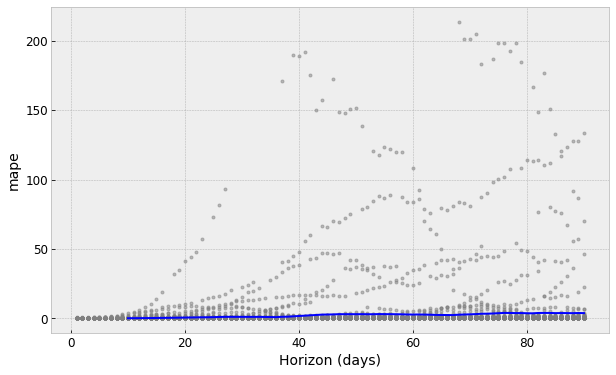

mape: 231.41%


In [139]:
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

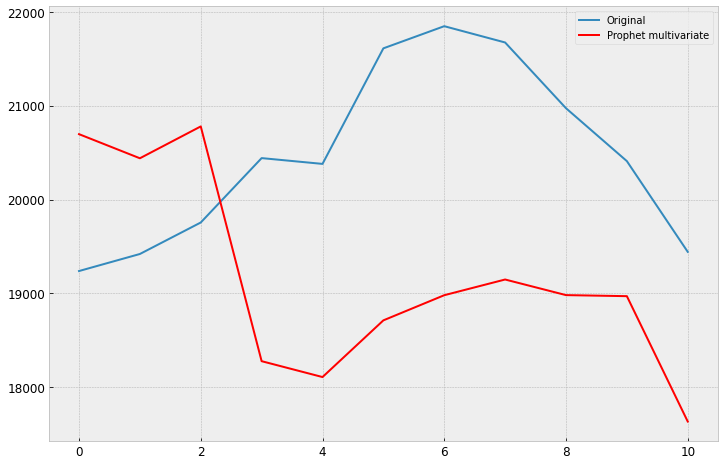

In [222]:
plt.plot(df_test.XBTUSD.values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet multivariate')
plt.legend()

In [223]:
increase = 1 - (resultsDict['Prophet multivariate']
                ['me']/resultsDict['Prophet multivariate']['mae'])
print(
    f"cross_validation Tunned Prophet multivariate is {increase*100}% better than the Prophet multivariate with default parameters")

cross_validation Tunned Prophet multivariate is 32.630169241772045% better than the Prophet multivariate with default parameters


In [224]:
cv_results_en = pd.DataFrame(grid.cv_results_)
cv_results_en.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006611,0.005399,0.000931,0.000270,1.0,{'alpha': 1.0},-28.813030,-2.229265,-56.890578,0.272708,-1.043029,-17.740639,22.357143,1
1,0.001792,0.000055,0.000680,0.000024,0.1,{'alpha': 0.1},-30.543543,-2.507980,-54.688761,0.278168,-1.445967,-17.781617,21.685467,2
2,0.001801,0.000106,0.000760,0.000147,0.01,{'alpha': 0.01},-33.584232,-3.848389,-48.851982,0.314813,-3.091752,-17.812308,19.761039,3
3,0.001805,0.000188,0.000672,0.000004,0.001,{'alpha': 0.001},-35.179856,-5.211630,-46.351434,0.335845,-4.149540,-18.111323,18.923373,4
4,0.001815,0.000184,0.000667,0.000011,0.0001,{'alpha': 0.0001},-35.410391,-5.446810,-46.019354,0.338971,-4.312454,-18.170008,18.811224,5


In [251]:
y_pred = grid.predict(X_test)


In [252]:
results = pd.DataFrame(zip(y_test, y_pred, y_test - y_pred), columns = ['y_test', 'y_pred', 'error'])
results.head(20)

,y_test,y_pred,error
0,19238.99,25589.550053,-6350.560053
1,19420.48,25689.932210,-6269.452210
2,19755.85,25487.668719,-5731.818719
3,20441.63,28113.934866,-7672.304866
4,20380.00,27506.599434,-7126.599434
5,21610.58,28750.149243,-7139.569243
6,21846.53,28485.193838,-6638.663838
7,21672.98,28610.200428,-6937.220428
8,20972.87,28612.291585,-7639.421585
9,20409.54,27686.375532,-7276.835532


In [ ]:
# Support vector machines


In [272]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_date = '2022-07-01'
df_training = bf.loc[bf.index <= split_date]
df_test = bf.loc[bf.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1658 days of training data 
 11 days of testing data 


In [273]:
train = bf[0:1658]
test = bf[1658:]

In [274]:
X_train_df, y_train = create_time_features(
    df_training, target='XBTUSD')
X_test_df, y_test = create_time_features(df_test, target='XBTUSD')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [558]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF'] = evaluate(df_test.XBTUSD, yhat)
predictionsDict['SVM RBF'] = yhat

Unable to compute metric mda: ('Lengths must match to compare', (11,), (10,))


In [257]:
resultsDict['SVM RBF']

{'nrmse': 0.7443169120291382,
 'mape': 0.08692262379238179,
 'mdape': 0.10111896719285675,
 'smape': 0.09144300122341593,
 'smdape': 0.10650374135695205,
 'maape': 0.08662450611663267,
 'mase': inf,
 'std_ae': 747.0748747317468,
 'std_ape': 0.033312566423016915,
 'rmspe': 0.09254396430068469,
 'rmdspe': 0.10111896719285675,
 'rmsse': inf,
 'inrse': 2.1351025878277756,
 'rrse': 2.1351025878277756,
 'mre': 20072778893259.906,
 'rae': 2.3559689444716048,
 'mrae': 20072778893259.906,
 'mdrae': nan,
 'gmrae': nan,
 'mbrae': 0.9999999999999426,
 'umbrae': 17422048848627.611,
 'mda': nan,
 'bias': 1805.3980835499785,
 'r2': -3.5586630605488647,
 'mse': 3766844.847772713,
 'rmse': 1940.836120792457,
 'me': 1805.3980835499785,
 'mae': 1805.3980835499785,
 'mad': 1805.3980835499785,
 'gmae': 1622.249228496137,
 'mdae': 2111.062485222479}

In [258]:
predictionsDict['SVM RBF']

array([18702.23189348, 18530.79722914, 18731.47456124, 18108.3235237 ,
       18268.93751478, 19062.29573925, 19243.85444329, 19120.95772375,
       18852.11504653, 18526.20321438, 18186.1601914 ])

In [ ]:
reg = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF GRID SEARCH'] = evaluate(df_test.XBTUSD, yhat)
predictionsDict['SVM RBF GRID SEARCH'] = yhat

In [269]:
increase = 1 - (resultsDict['SVM RBF GRID SEARCH']
                ['r2']/resultsDict['SVM RBF']['mae'])
print(
    f"Grid search Tunned SVM is {increase*100}% better than the SVM with default parameters")

Grid search Tunned SVM is 101.23934229899905% better than the SVM with default parameters


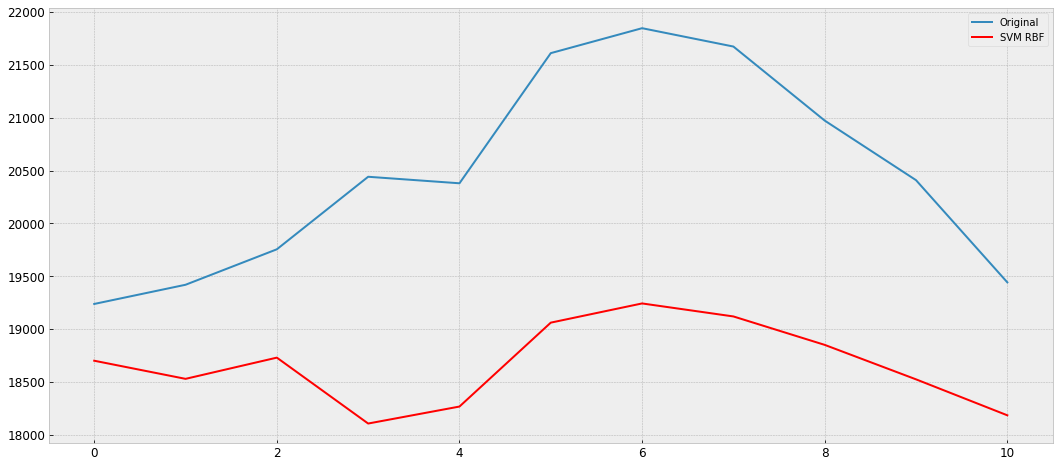

In [280]:
plt.plot(df_test.XBTUSD.values, label='Original')
plt.plot(yhat, color='red', label='SVM RBF')
plt.legend()

In [283]:
cv_results_en = pd.DataFrame(reg.cv_results_)
cv_results_en.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.117647,0.005058,0.034133,0.000825,1.0,0.01,"{'C': 1.0, 'gamma': 0.01}",-1.110377,-3.904371,-3.985773,-2.423655,-10.702371,-4.425310,3.312445,4
1,0.141588,0.038111,0.043819,0.011715,1.0,0.1,"{'C': 1.0, 'gamma': 0.1}",-1.120579,-3.959543,-4.112941,-2.429563,-10.717209,-4.467967,3.310519,13
2,0.204446,0.004153,0.055561,0.005052,1.0,1.0,"{'C': 1.0, 'gamma': 1.0}",-1.113339,-3.984214,-3.943082,-2.446271,-10.761955,-4.449772,3.330554,9
3,0.147399,0.032721,0.037858,0.003273,1.0,10.0,"{'C': 1.0, 'gamma': 10.0}",-1.113689,-3.982940,-3.939735,-2.446102,-10.761413,-4.448776,3.330436,8
4,0.095930,0.002481,0.027523,0.001271,1.0,100.0,"{'C': 1.0, 'gamma': 100.0}",-1.113689,-3.982940,-3.939735,-2.446102,-10.761413,-4.448776,3.330436,7


In [284]:
y_pred = reg.predict(X_test)


In [285]:
results = pd.DataFrame(zip(y_test, y_pred, y_test - y_pred), columns = ['y_test', 'y_pred', 'error'])
results.head(10)

,y_test,y_pred,error
0,19238.99,25146.596146,-5907.606146
1,19420.48,25217.866781,-5797.386781
2,19755.85,25875.871310,-6120.021310
3,20441.63,23785.695575,-3344.065575
4,20380.00,23597.495322,-3217.495322
5,21610.58,24928.420112,-3317.840112
6,21846.53,25209.066555,-3362.536555
7,21672.98,25265.610128,-3592.630128
8,20972.87,25369.322820,-4396.452820
9,20409.54,24576.171302,-4166.631302


In [ ]:
# Deep learning
# 1,Tensorlfow LSTM

In [504]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_date = '2022-07-01'
df_training = bf.loc[bf.index <= split_date]
df_test = bf.loc[bf.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1658 days of training data 
 11 days of testing data 


In [505]:
train = bf[0:1658]
test = bf[1658:]

In [506]:
X_train_df, y_train = create_time_features(
    df_training, target='XBTUSD')
X_test_df, y_test = create_time_features(df_test, target='XBTUSD')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [539]:
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24


def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [540]:
def define_model(dropout_rate=0.0, weight_constraint=0, neurons=10):
  dropout = 0.0
  simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)

])

#simple_lstm_model.compile(optimizer='rmsprop', loss='mape')

In [541]:
simple_lstm_model.compile(optimizer='rmsprop', loss='mape')

In [542]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50) 

Epoch 1/10
200/200 [==============================] - 13s 54ms/step - loss: 3.0663 - val_loss: 13.0613
Epoch 2/10
200/200 [==============================] - 9s 45ms/step - loss: 2.8800 - val_loss: 13.3471
Epoch 3/10
200/200 [==============================] - 9s 45ms/step - loss: 2.7630 - val_loss: 10.4400
Epoch 4/10
200/200 [==============================] - 9s 45ms/step - loss: 2.8343 - val_loss: 14.4792
Epoch 5/10
200/200 [==============================] - 9s 45ms/step - loss: 2.7590 - val_loss: 14.5144
Epoch 6/10
200/200 [==============================] - 9s 44ms/step - loss: 2.6815 - val_loss: 14.9378
Epoch 7/10
200/200 [==============================] - 9s 45ms/step - loss: 2.6966 - val_loss: 14.9353
Epoch 8/10
200/200 [==============================] - 9s 44ms/step - loss: 2.7322 - val_loss: 13.0855
Epoch 9/10
200/200 [==============================] - 9s 45ms/step - loss: 2.6051 - val_loss: 13.1154
Epoch 10/10
200/200 [==============================] - 9s 45ms/step - loss: 2.525

In [543]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test, yhat)
predictionsDict['Tensorflow simple LSTM'] = yhat

Unable to compute metric mda: ('Lengths must match to compare', (11,), (10,))


In [425]:
results = pd.DataFrame(zip(y_test, yhat, y_test - yhat), columns = ['y_test', 'y_pred', 'error'])
results.head(20)

,y_test,y_pred,error
0,19238.99,19643.226562,-404.236562
1,19420.48,20689.875000,-1269.395000
2,19755.85,19019.664062,736.185937
3,20441.63,17052.609375,3389.020625
4,20380.00,16044.093750,4335.906250
5,21610.58,16514.296875,5096.283125
6,21846.53,17579.630859,4266.899141
7,21672.98,18086.105469,3586.874531
8,20972.87,18159.648438,2813.221562
9,20409.54,17790.648438,2618.891563


In [416]:
resultsDict['Tensorflow simple LSTM']

{'nrmse': 1.20775413089818,
 'mape': 0.13386405254642517,
 'mdape': 0.13413622277256218,
 'smape': 0.1458017141327349,
 'smdape': 0.1437792237672151,
 'maape': 0.13251605711951608,
 'mase': inf,
 'std_ae': 2054.2830689659427,
 'std_ape': 0.0979631696092326,
 'rmspe': 0.14979780309822202,
 'rmdspe': 0.13413622277256218,
 'rmsse': inf,
 'inrse': 3.4644906338490418,
 'rrse': 3.4644906338490418,
 'mre': 28415430815972.223,
 'rae': 3.6396055511557766,
 'mrae': 31236308593750.0,
 'mdrae': nan,
 'gmrae': nan,
 'mbrae': 0.9999999999999543,
 'umbrae': 21862134113448.008,
 'mda': nan,
 'bias': 2484.7625639204543,
 'r2': -11.002695352027734,
 'mse': 9917883.937824434,
 'rmse': 3149.2672064822373,
 'me': 2484.7625639204543,
 'mae': 2789.059211647727,
 'mad': 2789.059211647727,
 'gmae': 2233.4699584551386,
 'mdae': 2813.221562499999}

In [417]:
predictionsDict['Tensorflow simple LSTM']

array([19643.227, 20689.875, 19019.664, 17052.61 , 16044.094, 16514.297,
       17579.63 , 18086.105, 18159.648, 17790.648, 17280.543],
      dtype=float32)

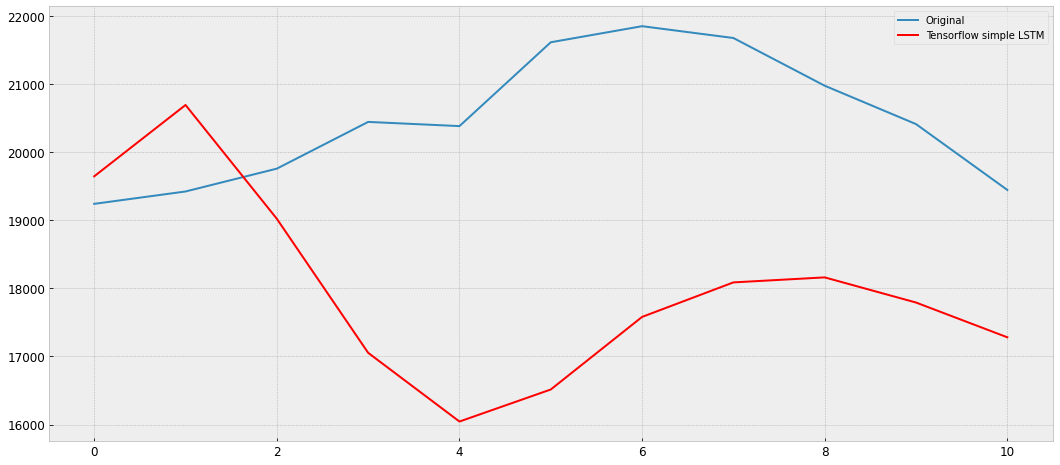

In [426]:
plt.plot(df_test.XBTUSD.values, label='Original')
plt.plot(yhat, color='red', label='Tensorflow simple LSTM')
plt.legend()

In [ ]:
# 2.DeepAR


In [481]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_date = '2022-07-01'
df_training = bf.loc[bf.index <= split_date]
df_test = bf.loc[bf.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1658 days of training data 
 11 days of testing data 


In [482]:
train = bf[0:1658]
test = bf[1658:]

In [483]:
X_train_df, y_train = create_time_features(
    df_training, target='XBTUSD')
X_test_df, y_test = create_time_features(df_test, target='XBTUSD')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [559]:
features = ['SPX Index', 'MXEU Index', 'NKY Index', 'SHCOMP Index', 'SENSEX Index',
            'MCX Index', 'CO1 Comdty', 'XAU Index', 'hour', 'dayofweek', 'quarter', 'month',
            'year', 'dayofyear', 'sin_day', 'cos_day', 'dayofmonth', 'weekofyear']

scaler = StandardScaler()
scaler.fit(X_train)  # No cheating, never scale on the training+test!
df_training[features] = scaler.transform(df_training[features])
df_test[features] = scaler.transform(df_test[features])


training_data = ListDataset(
    [{"start": df_training.index[0], "target": df_training.XBTUSD,
      'feat_dynamic_real': [df_training[feature] for feature in features]
      }],
    freq="d"
)
test_data = ListDataset(
    [{"start": df_test.index[0], "target": df_test.XBTUSD,
      'feat_dynamic_real': [df_test[feature] for feature in features]
      }],
    freq="d"
)

In [560]:
estimator = DeepAREstimator(freq="d",
                            prediction_length=1, context_length=30,
                            trainer=Trainer(epochs=5))

predictor = estimator.train(training_data=training_data)


forecast_it, ts_it = make_evaluation_predictions(
    test_data, predictor=predictor, num_samples=len(df_test))

forecasts = list(forecast_it)
tss = list(ts_it)

100%|██████████| 50/50 [00:04<00:00, 10.90it/s, epoch=5/5, avg_epoch_loss=8.03]


In [561]:
yhat = forecasts[0].samples.reshape(1, -1)[0]
resultsDict['DeepAR'] = evaluate(y_test, yhat)
predictionsDict['DeepAR'] = yhat

Unable to compute metric mda: ('Lengths must match to compare', (11,), (10,))


In [487]:
resultsDict['DeepAR'] 

{'nrmse': 1.1691367071811785,
 'mape': 0.13666881961171298,
 'mdape': 0.15137652265025228,
 'smape': 0.13461637259641718,
 'smdape': 0.14072527152408812,
 'maape': 0.13534071112535898,
 'mase': inf,
 'std_ae': 5107.297266095917,
 'std_ape': 0.25173786246058916,
 'rmspe': 0.14980732237785438,
 'rmdspe': 0.15137652265025228,
 'rmsse': inf,
 'inrse': 3.353715022035207,
 'rrse': 3.353715022035207,
 'mre': -6676312890625.002,
 'rae': 3.629285514837093,
 'mrae': 25979906727430.555,
 'mdrae': nan,
 'gmrae': nan,
 'mbrae': 0.9999999999999493,
 'umbrae': 19709407559607.297,
 'mda': nan,
 'bias': -1201.7659339488637,
 'r2': -10.247404449024609,
 'mse': 9293783.492417885,
 'rmse': 3048.570729443207,
 'me': -1201.7659339488637,
 'mae': 2781.1508842329545,
 'mad': 2781.1508842329545,
 'gmae': 2465.0206588226615,
 'mdae': 2990.5718750000015}

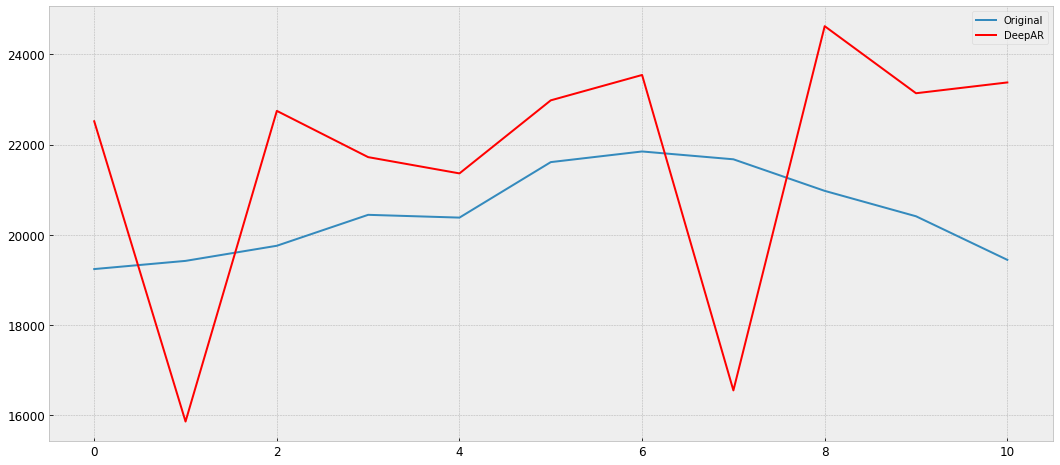

In [488]:
plt.plot(df_test.XBTUSD.values, label='Original')
plt.plot(yhat, color='red', label='DeepAR')
plt.legend()

In [490]:
results = pd.DataFrame(zip(y_test, yhat, y_test - yhat), columns = ['y_test', 'y_pred', 'error'])
results.head(10)

,y_test,y_pred,error
0,19238.99,22515.943359,-3276.953359
1,19420.48,15858.309570,3562.170430
2,19755.85,22746.421875,-2990.571875
3,20441.63,21720.886719,-1279.256719
4,20380.00,21360.146484,-980.146484
5,21610.58,22980.263672,-1369.683672
6,21846.53,23542.503906,-1695.973906
7,21672.98,16548.533203,5124.446797
8,20972.87,24624.406250,-3651.536250
9,20409.54,23137.669922,-2728.129922


In [544]:
models = ['Tensorflow simple LSTM',
          'Lightgbm',
          'XGBoost']
resis = pd.DataFrame(data={k: df_test.XBTUSD.values -
                     v for k, v in predictionsDict.items()})[models]
corr = resis.corr()
print("Residuals correlation")
corr.style.background_gradient(cmap='coolwarm')

Residuals correlation


,Tensorflow simple LSTM,Lightgbm,XGBoost
Tensorflow simple LSTM,1.000000,0.460643,-0.503328
Lightgbm,0.460643,1.000000,0.377203
XGBoost,-0.503328,0.377203,1.000000


In [545]:
predictionsDict['EnsembleXG+LIGHT'] = (
    predictionsDict['XGBoost'] + predictionsDict['Lightgbm'])/2
resultsDict['EnsembleXG+LIGHT'] = evaluate(
    df_test.XBTUSD.values, predictionsDict['EnsembleXG+LIGHT'])

predictionsDict['EnsembleXG+LIGHT+TF'] = (predictionsDict['XGBoost'] +
                                          predictionsDict['Lightgbm'] + predictionsDict['Tensorflow simple LSTM'])/3
resultsDict['EnsembleXG+LIGHT+TF'] = evaluate(
    df_test.XBTUSD.values, predictionsDict['EnsembleXG+LIGHT+TF'])

predictionsDict['EnsembleLIGHT+TF'] = (
    predictionsDict['Lightgbm'] + predictionsDict['Tensorflow simple LSTM'])/2
resultsDict['EnsembleLIGHT+TF'] = evaluate(
    df_test.XBTUSD.values, predictionsDict['EnsembleLIGHT+TF'])

predictionsDict['EnsembleXG+TF'] = (predictionsDict['XGBoost'] +
                                    predictionsDict['Tensorflow simple LSTM'])/2
resultsDict['EnsembleXG+TF'] = evaluate(
    df_test.XBTUSD.values, predictionsDict['EnsembleXG+TF'])

In [562]:
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels()
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

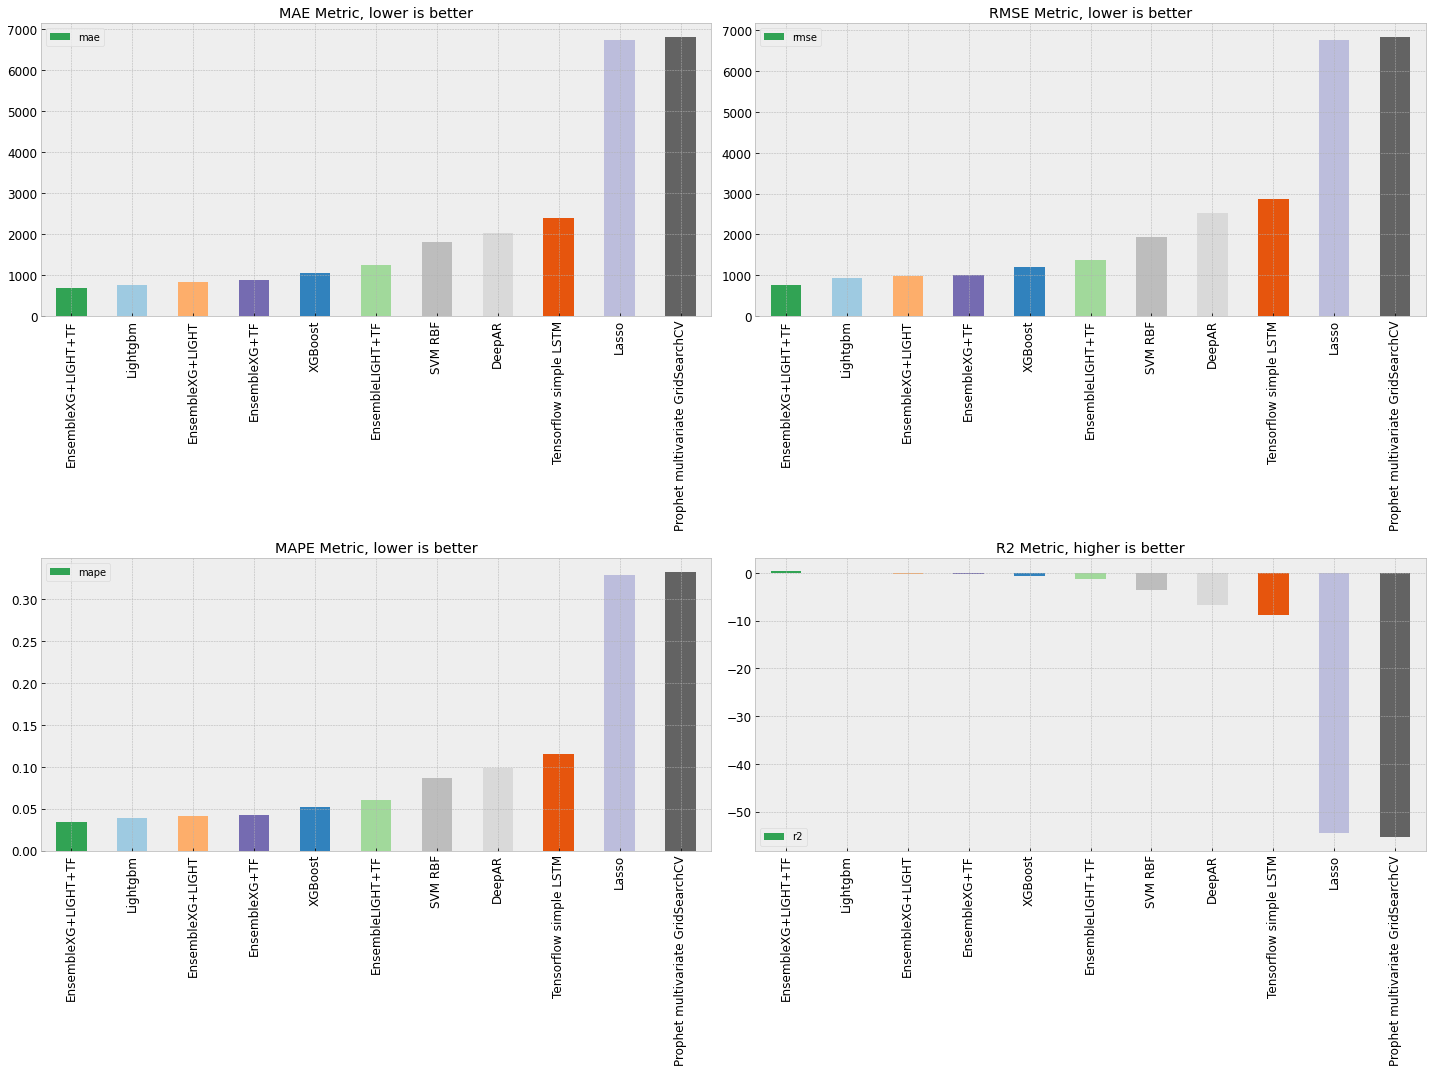

In [563]:
bar_metrics(resultsDict)


In [ ]:
# Feature importance


In [549]:
import shap


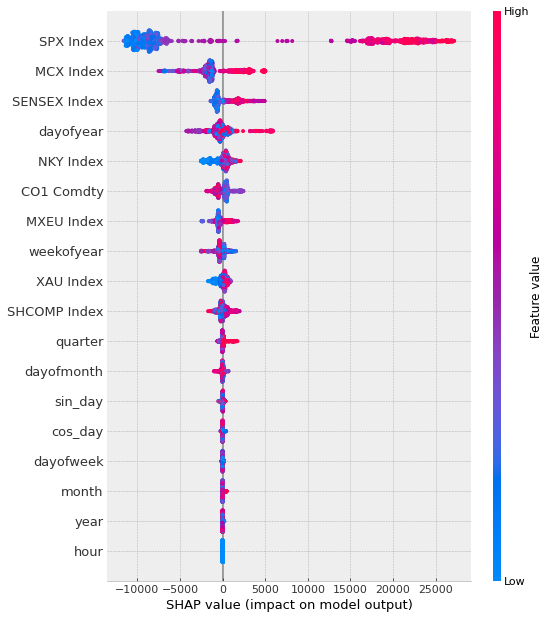

In [550]:
explainer = shap.TreeExplainer(lightGBM)
shap_values = explainer.shap_values(X_train_df)
shap.summary_plot(shap_values, X_train_df)

In [564]:
df = pd.DataFrame.from_dict(resultsDict).transpose().iloc[::-1]
df = df.round(2)
df

,nrmse,mape,mdape,smape,smdape,maape,mase,std_ae,std_ape,rmspe,...,mda,bias,r2,mse,rmse,me,mae,mad,gmae,mdae
DeepAR,0.96,0.10,0.09,0.09,0.09,0.10,inf,4344.84,0.21,0.12,...,NaN,-1658.05,-6.66,6328459.67,2515.64,-1658.05,2027.34,2027.34,1396.36,1752.49
SVM RBF,0.74,0.09,0.10,0.09,0.11,0.09,inf,747.07,0.03,0.09,...,NaN,1805.40,-3.56,3766844.85,1940.84,1805.40,1805.40,1805.40,1622.25,2111.06
Prophet multivariate GridSearchCV,2.62,0.33,0.33,0.28,0.28,0.32,inf,14276.51,0.70,0.33,...,NaN,-6799.02,-55.41,46609696.65,6827.13,-6799.02,6799.02,6799.02,6770.35,6937.22
Lasso,2.60,0.33,0.32,0.28,0.28,0.32,inf,14149.18,0.69,0.33,...,NaN,-6736.73,-54.49,45848707.58,6771.17,-6736.73,6736.73,6736.73,6701.38,6902.69
EnsembleXG+TF,0.39,0.04,0.03,0.04,0.03,0.04,1.73,955.76,0.05,0.05,...,0.7,551.21,-0.24,1020562.07,1010.23,551.21,888.41,888.41,499.55,696.72
EnsembleLIGHT+TF,0.53,0.06,0.05,0.06,0.05,0.06,2.44,1322.15,0.06,0.07,...,0.7,754.81,-1.31,1908746.48,1381.57,754.81,1254.96,1254.96,1106.81,1000.34
EnsembleXG+LIGHT+TF,0.29,0.03,0.04,0.03,0.04,0.03,1.35,952.22,0.05,0.04,...,0.8,161.68,0.31,566542.50,752.69,161.68,694.50,694.50,603.05,790.06
EnsembleXG+LIGHT,0.38,0.04,0.05,0.04,0.05,0.04,1.61,1819.44,0.09,0.05,...,0.6,-820.99,-0.17,966639.76,983.18,-820.99,827.28,827.28,491.27,941.94
Tensorflow simple LSTM,1.10,0.12,0.13,0.13,0.14,0.11,inf,2032.53,0.10,0.14,...,NaN,2127.01,-8.93,8202897.59,2864.07,2127.01,2404.33,2404.33,1759.97,2817.25
Lightgbm,0.35,0.04,0.03,0.04,0.03,0.04,inf,1616.80,0.08,0.05,...,NaN,-617.39,-0.03,849382.31,921.62,-617.39,763.99,763.99,520.78,558.30


In [552]:
import sklearn.metrics as metrics


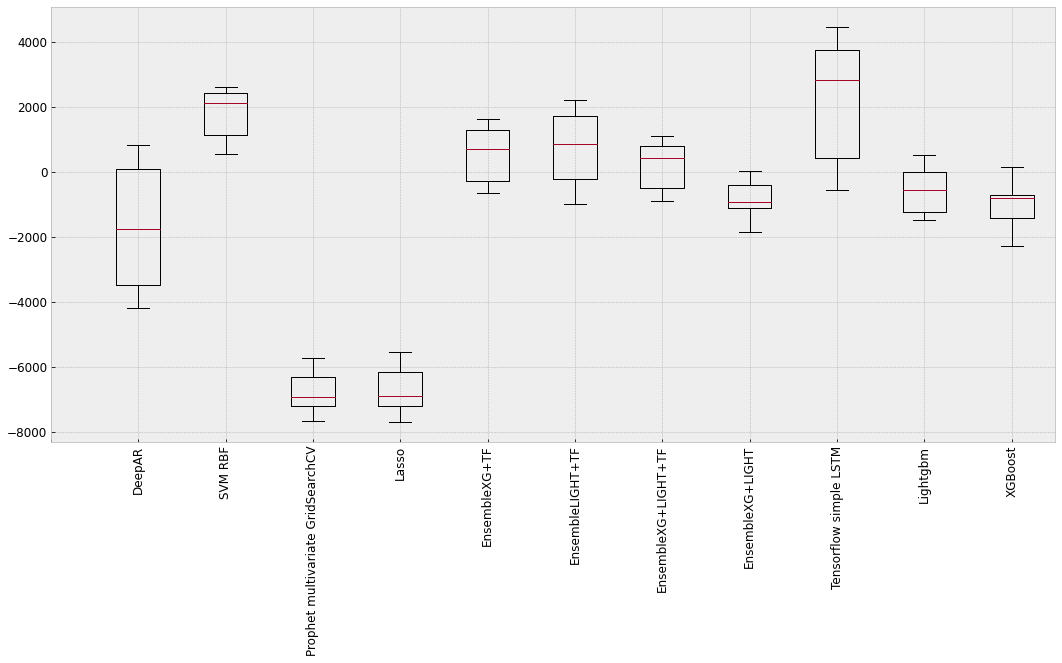

In [565]:
residuals = [df_test.XBTUSD.values - predictionsDict[u]
             for u in predictionsDict.keys()]
residuals.reverse()
plt.boxplot(residuals)
ticks = list(predictionsDict.keys())
ticks.reverse()
ticks = [''] + ticks
rang = range(0, len(ticks))
plt.xticks(rang, ticks, rotation='vertical')
pass